<a href="https://colab.research.google.com/github/pyagoubi/Credit-Default-Prediction/blob/main/Amex_XGBoost_fin_pd_V14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#set WD
import os
os.chdir('/content/drive/MyDrive/Amex/parquet')

# XGBoost 


# Load Libraries

In [3]:
# LOAD LIBRARIES
import pandas as pd, numpy as np # CPU libraries
#import cupy, cudf # GPU libraries
import matplotlib.pyplot as plt, gc, os

from sklearn.model_selection import KFold
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import csv, itertools

from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.inspection import permutation_importance
from tqdm.auto import tqdm

import itertools


#print('RAPIDS version',cudf.__version__)

In [4]:
# VERSION NAME FOR SAVED MODEL FILES
VER = 14

# TRAIN RANDOM SEED
SEED = 42

# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

# FOLDS PER MODEL
FOLDS = 5

NUM_PARTS = 10


TRAIN_PATH = 'train.parquet'
TEST_PATH = 'test.parquet'
TARGET_PATH = 'train_labels.csv'
SAVE_PATH = '/content/drive/MyDrive/Amex/parquet/XGB final/'
SUBMISSION_FILE_PATH = '/content/drive/MyDrive/Amex/parquet/sample_submission.csv'

# Process and Feature Engineer Train Data

In [7]:
def read_file(path = '', usecols = None):
    # LOAD DATAFRAME
    if usecols is not None: df = pd.read_parquet(path, columns=usecols)
    else: df = pd.read_parquet(path) #df = cudf.read_parquet(path)
    df['customer_ID'] = df['customer_ID'].str[-16:].apply(int, base =16)
    df.S_2 = pd.to_datetime( df.S_2 )
    print('shape of data:', df.shape)
    return df

def revertnan(df):
  df[df==-1] = np.nan 
  return df

def fill_na(df, NAN_VALUE):
  df = df.fillna(NAN_VALUE)
  return df

def numberobs_feature(df):
  df['number_of_observations'] = df.groupby('customer_ID')['customer_ID'].transform('count')
  df.loc[df['B_33'].isnull() & (df.number_of_observations==1),'number_of_observations'] = 0.5
  return df

def afterpay(df):
  # compute "after pay" features
  for bcol in [f'B_{i}_last' for i in [11,14,17]]+['D_39_last','D_131_last']+[f'S_{i}_last' for i in [16,23]]:
    for pcol in ['P_2_last','P_3_last']:
      if bcol in df.columns:
        df[f'{bcol}-{pcol}'] = df[bcol] - df[pcol]
  return df

def get_features(df):
  all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
  cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
  num_features = [col for col in all_cols if col not in cat_features]
  return all_cols, cat_features, num_features

def agg_functions(df, num_features, cat_features, numberobs = False#, exclnullCols, 
                  #dummy_nan_col
                  ):
  
  test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'max', 'min', 'last', 'first'])

  print('num agg complete')

  #test_nan_agg = df.groupby("customer_ID")[exclnullCols].agg(['last'])
  ##dummy_nan_col_agg = df.groupby("customer_ID")[dummy_nan_col].agg(['sum'])
  #df_presence_agg = df.groupby("customer_ID")['number_of_observations'].agg(['last'])
  
  test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
  print('cat agg complete')

  df = pd.concat([test_num_agg, test_cat_agg],   #dummy_nan_col_agg, 
                   # test_nan_agg], 
                   axis=1)
  
  print('concat complete')
  df.columns = ['_'.join(x) for x in df.columns]


  for col in num_features:
    if col not in ['number_of_observations']:
      max = f'{col}_max'
      min = f'{col}_min'
      df[f'{col}_minmax'] = df[max] -df[min]


  print('drop numberobs')

  if numberobs ==True:
    to_drop = ['number_of_observations_mean',  'number_of_observations_max','number_of_observations_min', 'number_of_observations_first']
    df.drop(to_drop, axis = 1, inplace = True)
    df.rename(columns={'number_of_observations_last':'number_of_observations'}, inplace = True)

  print('drop numberobs complete')
  del test_num_agg, test_cat_agg
  _ = gc.collect()
  print('shape after engineering', df.shape )
  return df

def add_meandev(df, num_features):
  
  for i in [f for f in num_features if f not in ['number_of_observations']]:
    last = f'{i}_last'
    mean = f'{i}_mean' 
    df[f'{i}_meandev'] = np.nan
    df.loc[(df[last] != np.nan), f'{i}_meandev'] = df[last] -df[mean]

  return df

def dropfirst(df):
  droplist = list(df.loc[:, df.columns.str.contains('first')].columns)
  df.drop(droplist, axis = 1, inplace = True)
  print('shape after engineering', df.shape )
  return df

def add_targets(df, TARGET_PATH):
  # ADD TARGETS
  targets = pd.read_csv(TARGET_PATH)
  targets['customer_ID'] = targets['customer_ID'].str[-16:].apply(int, base =16)
  targets = targets.set_index('customer_ID')
  df = df.merge(targets, left_index=True, right_index=True, how='left', sort = True)
  df.target = df.target.astype('int8')
  del targets

  # NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
  df = df.reset_index()
  return df


def get_difference(df, num_features, train_set = None, Part =None):
    df1 = []
    customer_ids = []
    for customer_id, cus in tqdm(df.groupby(['customer_ID'])):
        # Get the differences
        diff_df1 = cus[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        # Append to lists
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    # Concatenate
    df1 = np.concatenate(df1, axis = 0)
    # Transform to dataframe
    df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
    # Add customer id
    df1['customer_ID'] = customer_ids
    df1.set_index('customer_ID', inplace = True)
    if train_set == True: df1.to_parquet(f'{SAVE_PATH}diff_{VER}.parquet')
    elif train_set == False: df1.to_parquet(f'{SAVE_PATH}diff_test_{VER}_num{Part}.parquet')
    return df1
  
def onehot_encoding(df, cat_cols):
  cat_cols = [f'{i}_last' for i in cat_cols]
  for col in cat_cols:
    df = pd.get_dummies(df, columns=[col], drop_first=True)
  return df


In [8]:
#all functions compact
def preprocess(PATH = TRAIN_PATH, TARGET_PATH = TARGET_PATH, train_set = True, test = None, Part = None):
  if train_set == True:
    df = read_file(path = TRAIN_PATH)
  else:
    df = test
  print('read file complete')
  df = revertnan(df)
  print('revertnan complete')
  df = numberobs_feature(df)
  print('numberobs complete')
  all_cols, cat_features, num_features = get_features(df)
  print('get features complete')
  #diff1 = get_difference(df, num_features, train_set = train_set, Part = Part)
  if train_set == True: diff1 = pd.read_parquet(f'{SAVE_PATH}diff_12.parquet')
  elif train_set == False: diff1 = pd.read_parquet(f'{SAVE_PATH}diff_test_12_num{Part}.parquet')
  print('get diff complete')
  df = agg_functions(df, num_features, cat_features, numberobs = True)
  df = df.merge(diff1, left_index=True, right_index=True, how='left') 
  del diff1
  _ = gc.collect()
  print('agg features complete')
  df = add_meandev(df, num_features)
  print('meandev complete')
  df = afterpay(df)
  print('afterpay complete')
  df = onehot_encoding(df, cat_cols=cat_features)
  print('onehot complete')
  # df = add_Bratios(df)
  df = fill_na(df, NAN_VALUE)
  print('fillna complete')
  gc.collect()
  if train_set == True:
    df = add_targets(df, TARGET_PATH)
  return df

In [9]:
train = preprocess(PATH = TRAIN_PATH)

shape of data: (5531451, 190)
read file complete
revertnan complete
numberobs complete
get features complete
get diff complete
num agg complete
cat agg complete
concat complete


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


drop numberobs
drop numberobs complete
shape after engineering (458913, 1096)
agg features complete


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


meandev complete
afterpay complete


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


onehot complete
fillna complete


In [10]:
train.to_parquet(f'{SAVE_PATH}train_{VER}.parquet')

In [ ]:
train = pd.read_parquet(f'{SAVE_PATH}train_{VER}.parquet')

In [11]:
gc.collect()

140

In [9]:
#del test
gc.collect()
#train['number_of_observations']

473

In [12]:
def get_feature_list(df):
  features = df.columns[1:-1]
  print(f'There are {len(features)} features!')
  return features

In [13]:
features = get_feature_list(train)

There are 1487 features!


In [ ]:
features

In [14]:
def save_features(features):
  with open(f'{SAVE_PATH}features_V{VER}.csv', 'w') as csvfile:
    # creating a csv writer object
    writer = csv.writer(csvfile)    
    writer.writerow(features) 

In [15]:
save_features(features)

In [ ]:
del features

In [ ]:
features = pd.read_csv(f'{SAVE_PATH}features_V{VER}.csv')
features = pd.Index(features.columns)


Train XGB

In [16]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [17]:
def get_xgb_parameters():

  # XGB MODEL PARAMETERS
  # xgb_parms = { 
  #   'max_depth':4, 
  #   'learning_rate':0.05, 
  #   'subsample':0.8,
  #   'colsample_bytree':0.6, 
  #   'eval_metric':'logloss',
  #   'objective':'binary:logistic',
  #   'tree_method':'gpu_hist',
  #   'predictor':'gpu_predictor',
  #   'random_state':SEED
  # }
  xgb_parms = {
   'lambda': 0.19846538518330817, 
   'alpha': 0.11499421368543077, 
   'colsample_bytree': 1.0, 
   'subsample': 0.6, 
   'learning_rate': 0.01, 
   'max_depth': 8, 
   'min_child_weight': 56,
   'eval_metric':'logloss',
   'objective':'binary:logistic',
   'tree_method':'gpu_hist',
   'predictor':'gpu_predictor',
   'random_state':SEED  
    }
  # xgb_parms = {'lambda': 0.01266408599670852, 
  #  'alpha': 0.006135780234755984, 
  #  'colsample_bytree': 0.6, 
  #  'subsample': 0.9, 
  #  'learning_rate': 0.01, 
  #  'max_depth': 7, 
  #  'min_child_weight': 193,
  #  'eval_metric':'logloss',
  #  'objective':'binary:logistic',
  #  'tree_method':'gpu_hist',
  #  'predictor':'gpu_predictor',
  #  'random_state':SEED 
  #  }
  
  
  
  
  return xgb_parms

In [18]:
xgb_parms = get_xgb_parameters()

In [19]:
def train_model(df, SEED=SEED, SAVE_PATH =SAVE_PATH, VER=VER):
  importances = []
  oof = []
  TRAIN_SUBSAMPLE = 1.0
  gc.collect()
  kaggle_metrics_folds =[]

  skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
  for fold,(train_idx, valid_idx) in enumerate(skf.split(
            df, df.target )):
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    #Xy_train = IterLoadForDMatrix(train.loc[train_idx], features, 'target')

    X_train = df.loc[train_idx, features]
    y_train = df.loc[train_idx, 'target']

    X_valid = df.loc[valid_idx, features]
    y_valid = df.loc[valid_idx, 'target']
    
    #dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)

    dtrain = xgb.DMatrix(data=X_train, label=y_train)   
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'{SAVE_PATH}XGB_v{VER}_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df_pred = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df_pred)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_valid.values, oof_preds)
    print('Kaggle Metric =',acc,'\n')
    kaggle_metrics_folds.append(acc)
    
    # SAVE OOF
    df_pred = df.loc[valid_idx, ['customer_ID','target'] ].copy()
    df_pred['oof_pred'] = oof_preds
    oof.append( df_pred )
    
    del dtrain, X_train, y_train, dd, df_pred #,Xy_train,
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    
  print('#'*25)
  oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
  acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
  print('OVERALL CV Kaggle Metric =',acc)
  print(kaggle_metrics_folds)

In [20]:
train_model(train)

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100% fold data...
#########################
[0]	train-logloss:0.6864	valid-logloss:0.686443
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.35617	valid-logloss:0.359995
[200]	train-logloss:0.26576	valid-logloss:0.272529
[300]	train-logloss:0.233921	valid-logloss:0.243108
[400]	train-logloss:0.220588	valid-logloss:0.231832
[500]	train-logloss:0.214086	valid-logloss:0.227024
[600]	train-logloss:0.209649	valid-logloss:0.224322
[700]	train-logloss:0.206023	valid-logloss:0.222533
[800]	train-logloss:0.203194	valid-logloss:0.221322
[900]	train-logloss:0.200638	valid-logloss:0.220337
[1000]	train-logloss:0.198358	valid-logloss:0.219597
[1100]	train-logloss:0.19619	valid-logloss:0.218953
[1200]	train-logloss:0.194168	valid-logloss:0.218411
[1300]	train-logloss:0.192293	valid-lo

In [17]:
gc.collect()

667



```
base = 0.791536
ohne na Behandlung = 0.790870
na fill nach agg = 0.7916640
revertnan und na_fill nach agg = 0.791823
mit number of obs (und na_fill nach agg) = 0.79223834
so mit growth feature = 0.79185923 ??
mit abschange = 0.7917617 ??
mit abschange nicht skaliert = 0.791859 ?
number of obs in buckets (größer 10) + abschange = 0.7915386 ?
mit number_of_obs und min-max = 0.792181
mit number of obs (und na_fill nach agg)fillna vor meandev + mean deviation = 0.792464
mit number of obs (und na_fill nach agg) fillna nach meandev + mean deviation = 0.79237036 (=VER 1, 0.794 public lb)
s.o. + after pay features = 0.79310
VER 3: s.o. mit getunten Hyperparametern = 0.794355 (V3, 0.796 public lb)
s.o. mit B_29 = 0.794610 (v5, 0.796 public lb)
so ohne B_29 mit 1:100 Bratios = 0.7951046
so mit allen Bratios = 0.7952144 (0.795 lb)
VER 3 + first: 0.794577
Ver 3 + forst + first diff = 0.7955055
Ver 3 +  first diff = 0.79504522 ( 0.796735284564001, 0.79686627331464, 0.7968411263507417, 0.7920236043263609, 0.793339220870202 )

V7 = V3 + first + first diff = OVERALL CV Kaggle Metric = 0.7951661498772574 (LB 0.797)
[0.7962198773071689, 0.7965380847686576, 0.7972899788446302, 0.7909934597488399, 0.794277615381761] (Unterschied zu so 0.7955 konnte nicht nachvollzogen werden)

V9 = V9 mit getunten hyperparametern :OVERALL CV Kaggle Metric = 0.795368601110926
[0.7954320326411877, 0.7974078889361778, 0.7973913538116686, 0.7913097036060067, 0.7957431778045534]

V12: after pay nur mit last, one hot encoding OVERALL CV Kaggle Metric = 0.7957373107518337 (lb 0.797)
[0.7969486198782119, 0.7962363538077044, 0.7973269062536987, 0.7920697622584665, 0.7955655878459955]

V13: mit maxmin, ohne std, ohne min, OVERALL CV Kaggle Metric = 0.7953608849564417 (0.796 lb)
[0.7968882798164574, 0.7964878206575973, 0.7974681877663161, 0.7917797910863018, 0.793948382819542]

V14: mit min, ohne std: OVERALL CV Kaggle Metric = 0.7952813107927237
[0.7969120719048222, 0.7965001952586592, 0.7967465309957907, 0.7922152777481679, 0.7941480645671318]


Prepare Testdata

In [18]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = NUM_PARTS, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

In [19]:
def get_rowsnumcust(TEST_PATH, NUM_PARTS=NUM_PARTS):
  print(f'Reading test data...')
  test = read_file(path = TEST_PATH, usecols = ['customer_ID','S_2'])
  customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
  rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')
  return rows,num_cust,customers

In [20]:
rows,num_cust, customers = get_rowsnumcust(TEST_PATH, NUM_PARTS=NUM_PARTS)

Reading test data...
shape of data: (11363762, 2)
We will process test data as 10 separate parts.
There will be 92462 customers in each part (except the last part).
Below are number of rows in each part:
[1136415, 1137255, 1135580, 1135734, 1136082, 1137166, 1136612, 1137228, 1136301, 1135389]


In [22]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
  # READ PART OF TEST DATA
  print(f'\nReading test data...')
  test = read_file(path = TEST_PATH)
  test = test.sort_index()
  test = test.iloc[skip_rows:skip_rows+rows[k]]
  skip_rows += rows[k]
  print(f'=> Test part {k+1} has shape', test.shape )
    
  # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
  test = preprocess(train_set = False, test = test, Part =k)
  if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
  else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
  skip_cust += num_cust
 
   
  #ammend for one hot encoding
  test['D_64_last_1.0'] = 0
  test['D_66_last_1.0'] = 0
  test['D_68_last_1.0'] = 0
  # TEST DATA FOR XGB
  X_test = test[features]
  print('X_test complete')
  dtest = xgb.DMatrix(data=X_test)
  print('dtest complete')
  #test = test[['P_2_mean']] # reduce memory
  del test, X_test
  gc.collect()
  gc.collect()

  # INFER XGB MODELS ON TEST DATA
  model = xgb.Booster()
  model.load_model(f'{SAVE_PATH}XGB_v{VER}_fold0.xgb')
  print('load model complete')
  preds = model.predict(dtest)
  print('preds complete')
  for f in range(1,FOLDS):
    del model
    gc.collect()
    model = xgb.Booster()
    model.load_model(f'{SAVE_PATH}XGB_v{VER}_fold{f}.xgb')
    print(f'load {f} complete')
    preds += model.predict(dtest)
    print(f'preds {f} complete')
  preds /= FOLDS
  test_preds.append(preds)

  # CLEAN MEMORY
  del dtest, model
  _ = gc.collect()

test_preds = np.concatenate(test_preds)
#test = cudf.DataFrame(index=customers,data={'prediction':test_preds})
test = pd.DataFrame(index=customers,data={'prediction':test_preds})
#sub = cudf.read_csv(SUBMISSION_FILE_PATH)[['customer_ID']]
sub = pd.read_csv(SUBMISSION_FILE_PATH)[['customer_ID']]
#sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].apply(int, base =16)
sub = sub.set_index('customer_ID_hash')
#sub = sub.set_index('customer_ID')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

sub.to_csv(f'{SAVE_PATH}submission_xgb_v{VER}.csv',index=False)
print('Submission file shape is', sub.shape )
sub.head()


Reading test data...
shape of data: (11363762, 190)
=> Test part 1 has shape (1136415, 190)
read file complete
revertnan complete
numberobs complete
get features complete
get diff complete
num agg complete
cat agg complete
concat complete


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


drop numberobs
drop numberobs complete
shape after engineering (92462, 919)
agg features complete


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


meandev complete
afterpay complete


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


onehot complete
fillna complete
X_test complete
dtest complete
load model complete
preds complete
load 1 complete
preds 1 complete
load 2 complete
preds 2 complete
load 3 complete
preds 3 complete
load 4 complete
preds 4 complete

Reading test data...
shape of data: (11363762, 190)
=> Test part 2 has shape (1137255, 190)
read file complete
revertnan complete
numberobs complete
get features complete
get diff complete
num agg complete
cat agg complete
concat complete
drop numberobs
drop numberobs complete
shape after engineering (92462, 919)
agg features complete
meandev complete
afterpay complete
onehot complete
fillna complete
X_test complete
dtest complete
load model complete
preds complete
load 1 complete
preds 1 complete
load 2 complete
preds 2 complete
load 3 complete
preds 3 complete
load 4 complete
preds 4 complete

Reading test data...
shape of data: (11363762, 190)
=> Test part 3 has shape (1135580, 190)
read file complete
revertnan complete
numberobs complete
get features comp

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.035546
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000686
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.027861
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.201567
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.896911


In [43]:
gc.collect()

631

### ENDE

In [ ]:
train


,customer_ID,P_2_mean,P_2_std,P_2_max,P_2_min,P_2_last,P_2_first,D_39_mean,D_39_std,D_39_max,...,B_17-P_3_meandev,D_39-P_2_meandev,D_39-P_3_meandev,D_131-P_2_meandev,D_131-P_3_meandev,S_16-P_2_meandev,S_16-P_3_meandev,S_23-P_2_meandev,S_23-P_3_meandev,target
0,3249127622875,1.003573,0.001341,1.005004,1.002345,1.005004,1.002345,2.846154,6.841615,21,...,-127.000000,-0.001431,9.662469,-0.000816,-0.004198,-0.002197,-0.006118,-0.003054,-0.002010,0
1,23402014749356,0.415518,0.100825,0.498842,0.188222,0.215565,0.463519,3.230769,4.657500,15,...,0.398372,-2.030815,-1.767706,0.952465,1.215575,0.518049,0.781159,0.201210,0.464319,1
2,37423844044824,0.621856,0.032564,0.689850,0.583851,0.583851,0.689850,12.000000,12.006942,46,...,0.151129,1.038004,0.975343,0.038005,-0.024657,0.041275,-0.021386,0.418291,0.355629,1
3,149683802139734,0.913329,0.034975,0.976633,0.845514,0.931456,0.976633,3.230769,7.886210,21,...,-127.000000,-3.248897,-3.290519,-0.018127,-0.059750,-0.015045,-0.056667,0.048592,0.006970,0
4,160820792638518,0.555897,0.046583,0.662159,0.468876,0.518131,0.468876,1.384615,3.477031,11,...,-0.018422,-1.346849,-1.279861,0.037766,0.104755,0.040179,0.107168,0.040386,0.107375,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,18446623475205808948,0.342072,0.103027,0.486856,0.115548,0.115548,0.486856,2.076923,3.593085,11,...,0.273784,-1.850400,-1.783496,0.226523,0.293427,-0.861105,-0.794201,0.301186,0.368090,1
458909,18446629179309953275,0.242426,0.054706,0.317476,0.199567,0.215042,0.317476,13.571429,10.373960,24,...,0.000515,8.194051,5.000153,0.029562,0.002935,0.031139,0.003970,0.030783,0.002520,0
458910,18446635398005430687,0.541245,0.097363,0.666280,0.310770,0.445689,0.666280,0.000000,0.000000,0,...,-0.218169,0.095556,0.098894,0.095556,0.098894,5.205449,5.142211,0.002523,-0.002024,0
458911,18446654790786387807,0.996442,0.013313,1.009017,0.974290,0.974290,1.004322,0.000000,0.000000,0,...,-127.000000,0.022152,0.029393,0.022152,0.029393,0.022832,0.030073,0.024370,0.031610,0


In [ ]:
#train test split
train_df, test_df = train_test_split(train, test_size=0.25, stratify=train['target'])

In [ ]:
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 7.5 MB/s 
     |████████████████████████████████| 81 kB 10.9 MB/s 
     |████████████████████████████████| 209 kB 89.8 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 112 kB 75.6 MB/s 
     |████████████████████████████████| 147 kB 84.1 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=fe2cafc558545fd49c681822d02022893c2393d22e7f6cf9762f89c083d7c3aa
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
# optuna

def objective(trial,  train_df, test_df, features):
    
    param = {
        'booster':'gbtree',
        'tree_method':'gpu_hist', 
        "objective": "binary:logistic",
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_float(
            'colsample_bytree', 0.5,1,step=0.1
        ),
        'subsample': trial.suggest_float(
            'subsample', 0.5,1,step=0.1
        ),
        'learning_rate': trial.suggest_float(
            'learning_rate', 0.01,0.05,step=0.005
        ),
        'max_depth': trial.suggest_int(
            'max_depth', 4,9,1
        ),
        'random_state': 99,
        'eval_metric':'logloss',
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1,256,1
        ),
        
    }
    
    

    
    
    
    
    oof = []
    gc.collect()
    

        
    # TRAIN, VALID, TEST FOR FOLD K
    #Xy_train = IterLoadForDMatrix(train_df, features, 'target')

    X_train = train_df.loc[:, features]
    y_train = train_df.loc[:, 'target']    
        
    X_valid = test_df.loc[:, features]
    y_valid = test_df.loc[:, 'target']
      
    #dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)

    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
      
        

        
        # TRAIN MODEL FOLD K
    model = xgb.train(param, 
                  dtrain=dtrain,
                  evals=[(dtrain,'train'),(dvalid,'valid')],
                  num_boost_round=9999,
                  early_stopping_rounds=100,
                  verbose_eval=300
                  ) 
      
        
        # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
        #acc = amex_metric_mod(y_valid.values, oof_preds)
    
    
        # SAVE OOF
    df = test_df.loc[:, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append(df)

              


    del dtrain,  df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    

    oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
    metric = amex_metric_mod(oof.target.values, oof.oof_pred.values)
        
    return metric

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(
        trial,  train_df, test_df, features), n_trials= 100) 

[I 2022-08-09 06:48:44,778] A new study created in memory with name: no-name-39b9efc1-e01c-447c-8ee3-a3b2bd105442


[0]	train-logloss:0.674193	valid-logloss:0.674318
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.223103	valid-logloss:0.228805
[600]	train-logloss:0.213695	valid-logloss:0.222454
[900]	train-logloss:0.208983	valid-logloss:0.220383
[1200]	train-logloss:0.20533	valid-logloss:0.219312
[1500]	train-logloss:0.202316	valid-logloss:0.218717
[1800]	train-logloss:0.199581	valid-logloss:0.218312
[2100]	train-logloss:0.197083	valid-logloss:0.218081
[2400]	train-logloss:0.194739	valid-logloss:0.217962
[2700]	train-logloss:0.192462	valid-logloss:0.217793
[3000]	train-logloss:0.190138	valid-logloss:0.2177
Stopping. Best iteration:
[3020]	train-logloss:0.190009	valid-logloss:0.217689



[I 2022-08-09 06:54:55,284] Trial 0 finished with value: 0.792113440847197 and parameters: {'lambda': 0.8463220973716142, 'alpha': 0.004681316438506221, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 205}. Best is trial 0 with value: 0.792113440847197.


[0]	train-logloss:0.676616	valid-logloss:0.676759
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.212624	valid-logloss:0.224695
[600]	train-logloss:0.201281	valid-logloss:0.2198
[900]	train-logloss:0.1937	valid-logloss:0.218457
[1200]	train-logloss:0.187508	valid-logloss:0.217765
[1500]	train-logloss:0.182028	valid-logloss:0.217389
[1800]	train-logloss:0.176703	valid-logloss:0.217297
Stopping. Best iteration:
[1728]	train-logloss:0.178014	valid-logloss:0.217288



[I 2022-08-09 07:00:20,673] Trial 1 finished with value: 0.79436066369152 and parameters: {'lambda': 0.01784687958487909, 'alpha': 6.039315141982743, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.025, 'max_depth': 8, 'min_child_weight': 222}. Best is trial 1 with value: 0.79436066369152.


[0]	train-logloss:0.676801	valid-logloss:0.676901
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.214939	valid-logloss:0.225408
[600]	train-logloss:0.202551	valid-logloss:0.220092
[900]	train-logloss:0.194747	valid-logloss:0.218537
[1200]	train-logloss:0.188152	valid-logloss:0.217875
[1500]	train-logloss:0.182341	valid-logloss:0.217496
[1800]	train-logloss:0.176702	valid-logloss:0.217338
[2100]	train-logloss:0.17139	valid-logloss:0.217194
Stopping. Best iteration:
[2206]	train-logloss:0.169608	valid-logloss:0.217143



[I 2022-08-09 07:06:00,674] Trial 2 finished with value: 0.793634397593481 and parameters: {'lambda': 0.019933299168944874, 'alpha': 0.10288187044252886, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.025, 'max_depth': 6, 'min_child_weight': 59}. Best is trial 1 with value: 0.79436066369152.


[0]	train-logloss:0.661259	valid-logloss:0.661458
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.213988	valid-logloss:0.222435
[600]	train-logloss:0.205454	valid-logloss:0.2196
[900]	train-logloss:0.199381	valid-logloss:0.21879
Stopping. Best iteration:
[1008]	train-logloss:0.197399	valid-logloss:0.218591



[I 2022-08-09 07:08:47,435] Trial 3 finished with value: 0.7922928096359114 and parameters: {'lambda': 0.004610015408295761, 'alpha': 0.04948959414801683, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 220}. Best is trial 1 with value: 0.79436066369152.


[0]	train-logloss:0.686553	valid-logloss:0.686601
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.244951	valid-logloss:0.250122
[600]	train-logloss:0.221437	valid-logloss:0.229422
[900]	train-logloss:0.214249	valid-logloss:0.224607
[1200]	train-logloss:0.209968	valid-logloss:0.222234
[1500]	train-logloss:0.206728	valid-logloss:0.22084
[1800]	train-logloss:0.204132	valid-logloss:0.219959
[2100]	train-logloss:0.201841	valid-logloss:0.219362
[2400]	train-logloss:0.199765	valid-logloss:0.218946
[2700]	train-logloss:0.197878	valid-logloss:0.218636
[3000]	train-logloss:0.196059	valid-logloss:0.218388
[3300]	train-logloss:0.19442	valid-logloss:0.2182
[3600]	train-logloss:0.192779	valid-logloss:0.218049
[3900]	train-logloss:0.191232	valid-logloss:0.217921
[4200]	train-logloss:0.189778	valid-logloss:0.21784
[4500]	train-logloss:0.188293	valid-logloss:0.217751
[4800]	trai

[I 2022-08-09 07:22:06,302] Trial 4 finished with value: 0.7935877504068674 and parameters: {'lambda': 0.022730857097774008, 'alpha': 0.011930614844272257, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 240}. Best is trial 1 with value: 0.79436066369152.


[0]	train-logloss:0.676629	valid-logloss:0.676764
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.213724	valid-logloss:0.22501
[600]	train-logloss:0.202438	valid-logloss:0.219955
[900]	train-logloss:0.19534	valid-logloss:0.218431
[1200]	train-logloss:0.189472	valid-logloss:0.217805
[1500]	train-logloss:0.184423	valid-logloss:0.217465
[1800]	train-logloss:0.179493	valid-logloss:0.217325
[2100]	train-logloss:0.174813	valid-logloss:0.217226
[2400]	train-logloss:0.170133	valid-logloss:0.217171
Stopping. Best iteration:
[2464]	train-logloss:0.169255	valid-logloss:0.217139



[I 2022-08-09 07:28:49,911] Trial 5 finished with value: 0.7932480327806586 and parameters: {'lambda': 0.01312471330577307, 'alpha': 0.05024588292586385, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.025, 'max_depth': 7, 'min_child_weight': 210}. Best is trial 1 with value: 0.79436066369152.


[0]	train-logloss:0.6798	valid-logloss:0.67992
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.214607	valid-logloss:0.22631
[600]	train-logloss:0.202003	valid-logloss:0.22037
[900]	train-logloss:0.194366	valid-logloss:0.218728
[1200]	train-logloss:0.188184	valid-logloss:0.217976
[1500]	train-logloss:0.18258	valid-logloss:0.217599
[1800]	train-logloss:0.177273	valid-logloss:0.217403
[2100]	train-logloss:0.17214	valid-logloss:0.217336
Stopping. Best iteration:
[2036]	train-logloss:0.17321	valid-logloss:0.217325



[I 2022-08-09 07:35:22,213] Trial 6 finished with value: 0.7940699495359893 and parameters: {'lambda': 0.015078308428091661, 'alpha': 0.012820352432456938, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 9, 'min_child_weight': 233}. Best is trial 1 with value: 0.79436066369152.


[0]	train-logloss:0.664871	valid-logloss:0.66503
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.216663	valid-logloss:0.224371
[600]	train-logloss:0.206838	valid-logloss:0.219964
[900]	train-logloss:0.200497	valid-logloss:0.218533
[1200]	train-logloss:0.195197	valid-logloss:0.217942
[1500]	train-logloss:0.19038	valid-logloss:0.217646
[1800]	train-logloss:0.185844	valid-logloss:0.217412
Stopping. Best iteration:
[1814]	train-logloss:0.185607	valid-logloss:0.217401



[I 2022-08-09 07:39:18,087] Trial 7 finished with value: 0.7933736659518256 and parameters: {'lambda': 0.25631068933011186, 'alpha': 2.0669349377917787, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.045000000000000005, 'max_depth': 4, 'min_child_weight': 35}. Best is trial 1 with value: 0.79436066369152.


[0]	train-logloss:0.664864	valid-logloss:0.665035
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.215989	valid-logloss:0.224406
[600]	train-logloss:0.205939	valid-logloss:0.220054
[900]	train-logloss:0.199369	valid-logloss:0.218732
[1200]	train-logloss:0.193643	valid-logloss:0.218175
[1500]	train-logloss:0.188602	valid-logloss:0.217791
[1800]	train-logloss:0.183861	valid-logloss:0.217618
[2100]	train-logloss:0.179409	valid-logloss:0.217539
Stopping. Best iteration:
[2047]	train-logloss:0.180172	valid-logloss:0.217512



[I 2022-08-09 07:43:42,073] Trial 8 finished with value: 0.79400740164065 and parameters: {'lambda': 0.7913501320333705, 'alpha': 0.029397374178440395, 'colsample_bytree': 0.9, 'subsample': 0.9, 'learning_rate': 0.045000000000000005, 'max_depth': 4, 'min_child_weight': 42}. Best is trial 1 with value: 0.79436066369152.


[0]	train-logloss:0.676522	valid-logloss:0.676667
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.211113	valid-logloss:0.2241
[600]	train-logloss:0.198838	valid-logloss:0.219725
[900]	train-logloss:0.190511	valid-logloss:0.21848
[1200]	train-logloss:0.183634	valid-logloss:0.217954
[1500]	train-logloss:0.177126	valid-logloss:0.21766
Stopping. Best iteration:
[1699]	train-logloss:0.173194	valid-logloss:0.217502



[I 2022-08-09 07:49:16,504] Trial 9 finished with value: 0.7934747106542719 and parameters: {'lambda': 0.06254619314589088, 'alpha': 0.09420800661553026, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.025, 'max_depth': 9, 'min_child_weight': 249}. Best is trial 1 with value: 0.79436066369152.


[0]	train-logloss:0.686494	valid-logloss:0.68655
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.238751	valid-logloss:0.246221
[600]	train-logloss:0.215186	valid-logloss:0.226532
[900]	train-logloss:0.207571	valid-logloss:0.222278
[1200]	train-logloss:0.202705	valid-logloss:0.220329
[1500]	train-logloss:0.198938	valid-logloss:0.219237
[1800]	train-logloss:0.195544	valid-logloss:0.218509
[2100]	train-logloss:0.192536	valid-logloss:0.218041
[2400]	train-logloss:0.189689	valid-logloss:0.217657
[2700]	train-logloss:0.186984	valid-logloss:0.217385
[3000]	train-logloss:0.184311	valid-logloss:0.21718
[3300]	train-logloss:0.181824	valid-logloss:0.217026
[3600]	train-logloss:0.179367	valid-logloss:0.216913
[3900]	train-logloss:0.176975	valid-logloss:0.216806
[4200]	train-logloss:0.174591	valid-logloss:0.216709
[4500]	train-logloss:0.172259	valid-logloss:0.216622
[4800]	t

[I 2022-08-09 08:03:58,617] Trial 10 finished with value: 0.7942674281691859 and parameters: {'lambda': 0.0010685994711896343, 'alpha': 8.009063066601675, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 138}. Best is trial 1 with value: 0.79436066369152.


[0]	train-logloss:0.686502	valid-logloss:0.686559
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.239207	valid-logloss:0.246523
[600]	train-logloss:0.215599	valid-logloss:0.226657
[900]	train-logloss:0.208029	valid-logloss:0.22234
[1200]	train-logloss:0.203279	valid-logloss:0.220373
[1500]	train-logloss:0.199601	valid-logloss:0.219248
[1800]	train-logloss:0.196244	valid-logloss:0.218492
[2100]	train-logloss:0.19326	valid-logloss:0.217988
[2400]	train-logloss:0.190533	valid-logloss:0.217616
[2700]	train-logloss:0.187866	valid-logloss:0.217337
[3000]	train-logloss:0.185256	valid-logloss:0.21711
[3300]	train-logloss:0.18283	valid-logloss:0.216943
[3600]	train-logloss:0.180416	valid-logloss:0.216808
[3900]	train-logloss:0.178086	valid-logloss:0.216681
[4200]	train-logloss:0.175761	valid-logloss:0.216589
[4500]	train-logloss:0.173478	valid-logloss:0.216526
[4800]	tra

[I 2022-08-09 08:17:30,268] Trial 11 finished with value: 0.794397985189469 and parameters: {'lambda': 0.0012922329423008141, 'alpha': 9.685343062468263, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 142}. Best is trial 11 with value: 0.794397985189469.


[0]	train-logloss:0.683213	valid-logloss:0.683284
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.223321	valid-logloss:0.231731
[600]	train-logloss:0.209349	valid-logloss:0.222487
[900]	train-logloss:0.202468	valid-logloss:0.219808
[1200]	train-logloss:0.197339	valid-logloss:0.218708
[1500]	train-logloss:0.192984	valid-logloss:0.218079
[1800]	train-logloss:0.188963	valid-logloss:0.217646
[2100]	train-logloss:0.185064	valid-logloss:0.217352
[2400]	train-logloss:0.18138	valid-logloss:0.217185
[2700]	train-logloss:0.177814	valid-logloss:0.217051
Stopping. Best iteration:
[2768]	train-logloss:0.177029	valid-logloss:0.217025



[I 2022-08-09 08:25:37,866] Trial 12 finished with value: 0.7943049824246062 and parameters: {'lambda': 5.916445277902928, 'alpha': 1.0378866132183744, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.015, 'max_depth': 8, 'min_child_weight': 151}. Best is trial 11 with value: 0.794397985189469.


[0]	train-logloss:0.666805	valid-logloss:0.667064
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.198682	valid-logloss:0.220658
[600]	train-logloss:0.183752	valid-logloss:0.218303
[900]	train-logloss:0.171574	valid-logloss:0.217864
[1200]	train-logloss:0.160608	valid-logloss:0.217632
Stopping. Best iteration:
[1343]	train-logloss:0.155872	valid-logloss:0.217593



[I 2022-08-09 08:30:03,461] Trial 13 finished with value: 0.7944750772431789 and parameters: {'lambda': 0.0012300898939576292, 'alpha': 9.018182713332596, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.04, 'max_depth': 8, 'min_child_weight': 93}. Best is trial 13 with value: 0.7944750772431789.


[0]	train-logloss:0.666796	valid-logloss:0.666952
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.203415	valid-logloss:0.220888
[600]	train-logloss:0.189408	valid-logloss:0.218605
[900]	train-logloss:0.178524	valid-logloss:0.218291
Stopping. Best iteration:
[954]	train-logloss:0.176794	valid-logloss:0.218223



[I 2022-08-09 08:33:13,024] Trial 14 finished with value: 0.7920212904537132 and parameters: {'lambda': 0.0014699843223445728, 'alpha': 0.5149997093806993, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.04, 'max_depth': 7, 'min_child_weight': 94}. Best is trial 13 with value: 0.7944750772431789.


[0]	train-logloss:0.669972	valid-logloss:0.670146
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.204025	valid-logloss:0.221107
[600]	train-logloss:0.190512	valid-logloss:0.218651
[900]	train-logloss:0.180064	valid-logloss:0.218079
Stopping. Best iteration:
[1021]	train-logloss:0.176035	valid-logloss:0.217962



[I 2022-08-09 08:36:42,483] Trial 15 finished with value: 0.7924975349549309 and parameters: {'lambda': 0.0033838171637291838, 'alpha': 2.6552532258047727, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.035, 'max_depth': 8, 'min_child_weight': 95}. Best is trial 13 with value: 0.7944750772431789.


[0]	train-logloss:0.669344	valid-logloss:0.669817
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.143195	valid-logloss:0.220317
Stopping. Best iteration:
[453]	train-logloss:0.119596	valid-logloss:0.219631



[I 2022-08-09 08:39:09,150] Trial 16 finished with value: 0.7917453670523547 and parameters: {'lambda': 0.0031505389945183744, 'alpha': 0.0010837780026848284, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.035, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 13 with value: 0.7944750772431789.


[0]	train-logloss:0.670204	valid-logloss:0.670354
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.210311	valid-logloss:0.222342
[600]	train-logloss:0.199505	valid-logloss:0.219183
[900]	train-logloss:0.191592	valid-logloss:0.218319
[1200]	train-logloss:0.18441	valid-logloss:0.217864
[1500]	train-logloss:0.178133	valid-logloss:0.217788
Stopping. Best iteration:
[1408]	train-logloss:0.179974	valid-logloss:0.217715



[I 2022-08-09 08:43:23,344] Trial 17 finished with value: 0.7912832494744542 and parameters: {'lambda': 0.0010407563530333728, 'alpha': 0.28839698279848314, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.035, 'max_depth': 7, 'min_child_weight': 174}. Best is trial 13 with value: 0.7944750772431789.


[0]	train-logloss:0.68315	valid-logloss:0.68325
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.220252	valid-logloss:0.231507
[600]	train-logloss:0.205128	valid-logloss:0.222289
[900]	train-logloss:0.197323	valid-logloss:0.219757
[1200]	train-logloss:0.191426	valid-logloss:0.218571
[1500]	train-logloss:0.18643	valid-logloss:0.217946
[1800]	train-logloss:0.181587	valid-logloss:0.217528
[2100]	train-logloss:0.177083	valid-logloss:0.217285
[2400]	train-logloss:0.172915	valid-logloss:0.21706
[2700]	train-logloss:0.16883	valid-logloss:0.216961
[3000]	train-logloss:0.164929	valid-logloss:0.216893
[3300]	train-logloss:0.161156	valid-logloss:0.216819
Stopping. Best iteration:
[3370]	train-logloss:0.160277	valid-logloss:0.216786



[I 2022-08-09 08:53:28,383] Trial 18 finished with value: 0.7947706124716518 and parameters: {'lambda': 0.10342559235168247, 'alpha': 9.599122401644566, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.015, 'max_depth': 8, 'min_child_weight': 105}. Best is trial 18 with value: 0.7947706124716518.


[0]	train-logloss:0.66084	valid-logloss:0.661075
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.203105	valid-logloss:0.220916
[600]	train-logloss:0.189888	valid-logloss:0.21864
[900]	train-logloss:0.179276	valid-logloss:0.217993
Stopping. Best iteration:
[1084]	train-logloss:0.173448	valid-logloss:0.217853



[I 2022-08-09 08:56:36,155] Trial 19 finished with value: 0.7928551380264985 and parameters: {'lambda': 0.15214970336503697, 'alpha': 2.49725534436298, 'colsample_bytree': 1.0, 'subsample': 0.9, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 104}. Best is trial 18 with value: 0.7947706124716518.


[0]	train-logloss:0.682973	valid-logloss:0.683084
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.210687	valid-logloss:0.228453
[600]	train-logloss:0.192864	valid-logloss:0.220591
[900]	train-logloss:0.18232	valid-logloss:0.218645
[1200]	train-logloss:0.174033	valid-logloss:0.217736
[1500]	train-logloss:0.166555	valid-logloss:0.217247
[1800]	train-logloss:0.159667	valid-logloss:0.217045
[2100]	train-logloss:0.153349	valid-logloss:0.216887
[2400]	train-logloss:0.147491	valid-logloss:0.21678
Stopping. Best iteration:
[2470]	train-logloss:0.146061	valid-logloss:0.216749



[I 2022-08-09 09:04:38,137] Trial 20 finished with value: 0.7944205533927209 and parameters: {'lambda': 0.06487517616900781, 'alpha': 0.361058328620972, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 9, 'min_child_weight': 72}. Best is trial 18 with value: 0.7947706124716518.


[0]	train-logloss:0.682967	valid-logloss:0.683068
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.210886	valid-logloss:0.22855
[600]	train-logloss:0.193141	valid-logloss:0.220731
[900]	train-logloss:0.182518	valid-logloss:0.218751
[1200]	train-logloss:0.174239	valid-logloss:0.217858
[1500]	train-logloss:0.166777	valid-logloss:0.217351
[1800]	train-logloss:0.160024	valid-logloss:0.217051
[2100]	train-logloss:0.153753	valid-logloss:0.216917
Stopping. Best iteration:
[2297]	train-logloss:0.149865	valid-logloss:0.216879



[I 2022-08-09 09:12:14,025] Trial 21 finished with value: 0.7941452745750714 and parameters: {'lambda': 0.07768999211500285, 'alpha': 0.4738045651795699, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 9, 'min_child_weight': 74}. Best is trial 18 with value: 0.7947706124716518.


[0]	train-logloss:0.683072	valid-logloss:0.683174
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.21724	valid-logloss:0.229989
[600]	train-logloss:0.201925	valid-logloss:0.221443
[900]	train-logloss:0.193684	valid-logloss:0.21923
[1200]	train-logloss:0.18708	valid-logloss:0.218251
[1500]	train-logloss:0.181696	valid-logloss:0.217743
[1800]	train-logloss:0.176279	valid-logloss:0.21743
[2100]	train-logloss:0.17116	valid-logloss:0.217216
[2400]	train-logloss:0.166389	valid-logloss:0.217032
[2700]	train-logloss:0.161822	valid-logloss:0.216935
Stopping. Best iteration:
[2834]	train-logloss:0.15979	valid-logloss:0.216881



[I 2022-08-09 09:21:10,923] Trial 22 finished with value: 0.7943649035366254 and parameters: {'lambda': 0.400048773915842, 'alpha': 4.283716570119585, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.015, 'max_depth': 9, 'min_child_weight': 118}. Best is trial 18 with value: 0.7947706124716518.


[0]	train-logloss:0.679771	valid-logloss:0.679882
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.209046	valid-logloss:0.225463
[600]	train-logloss:0.193274	valid-logloss:0.219824
[900]	train-logloss:0.182843	valid-logloss:0.218193
[1200]	train-logloss:0.174384	valid-logloss:0.217553
[1500]	train-logloss:0.166718	valid-logloss:0.217148
[1800]	train-logloss:0.15987	valid-logloss:0.216981
Stopping. Best iteration:
[1827]	train-logloss:0.159234	valid-logloss:0.216939



[I 2022-08-09 09:26:57,425] Trial 23 finished with value: 0.7938671816191348 and parameters: {'lambda': 4.040342432142741, 'alpha': 1.0905871645258842, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 8, 'min_child_weight': 75}. Best is trial 18 with value: 0.7947706124716518.


[0]	train-logloss:0.679851	valid-logloss:0.679968
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.214916	valid-logloss:0.227015
[600]	train-logloss:0.201373	valid-logloss:0.220716
[900]	train-logloss:0.193522	valid-logloss:0.218926
[1200]	train-logloss:0.186842	valid-logloss:0.218079
[1500]	train-logloss:0.181194	valid-logloss:0.217619
[1800]	train-logloss:0.175611	valid-logloss:0.217326
[2100]	train-logloss:0.170687	valid-logloss:0.21716
[2400]	train-logloss:0.165749	valid-logloss:0.217078
Stopping. Best iteration:
[2357]	train-logloss:0.166437	valid-logloss:0.217058



[I 2022-08-09 09:33:29,021] Trial 24 finished with value: 0.7937964616589869 and parameters: {'lambda': 0.040308354266380915, 'alpha': 0.20948639540400785, 'colsample_bytree': 0.9, 'subsample': 0.9, 'learning_rate': 0.02, 'max_depth': 7, 'min_child_weight': 117}. Best is trial 18 with value: 0.7947706124716518.


[0]	train-logloss:0.672834	valid-logloss:0.673146
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.176509	valid-logloss:0.220799
[600]	train-logloss:0.149275	valid-logloss:0.218538
Stopping. Best iteration:
[787]	train-logloss:0.135676	valid-logloss:0.218367



[I 2022-08-09 09:36:47,655] Trial 25 finished with value: 0.7920564702709899 and parameters: {'lambda': 1.006976554632956, 'alpha': 1.2530815675568423, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.03, 'max_depth': 9, 'min_child_weight': 14}. Best is trial 18 with value: 0.7947706124716518.


[0]	train-logloss:0.66684	valid-logloss:0.667041
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.204747	valid-logloss:0.220984
[600]	train-logloss:0.192212	valid-logloss:0.218521
[900]	train-logloss:0.18254	valid-logloss:0.218065
[1200]	train-logloss:0.173165	valid-logloss:0.217782
Stopping. Best iteration:
[1167]	train-logloss:0.174217	valid-logloss:0.217755



[I 2022-08-09 09:40:39,524] Trial 26 finished with value: 0.7938108619217248 and parameters: {'lambda': 0.14907558642247606, 'alpha': 4.666451085178316, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.04, 'max_depth': 8, 'min_child_weight': 161}. Best is trial 18 with value: 0.7947706124716518.


[0]	train-logloss:0.683133	valid-logloss:0.683217
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.221126	valid-logloss:0.231639
[600]	train-logloss:0.204865	valid-logloss:0.222252
[900]	train-logloss:0.196413	valid-logloss:0.219648
[1200]	train-logloss:0.190054	valid-logloss:0.218476
[1500]	train-logloss:0.184604	valid-logloss:0.217832
[1800]	train-logloss:0.17967	valid-logloss:0.217499
[2100]	train-logloss:0.175041	valid-logloss:0.217276
[2400]	train-logloss:0.17069	valid-logloss:0.217061
[2700]	train-logloss:0.166555	valid-logloss:0.216907
Stopping. Best iteration:
[2820]	train-logloss:0.164787	valid-logloss:0.216869



[I 2022-08-09 09:48:22,704] Trial 27 finished with value: 0.7947115594370932 and parameters: {'lambda': 0.008959183257255634, 'alpha': 0.7310737021465465, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 74}. Best is trial 18 with value: 0.7947706124716518.


[0]	train-logloss:0.666958	valid-logloss:0.667143
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.207132	valid-logloss:0.221624
[600]	train-logloss:0.195546	valid-logloss:0.218921
[900]	train-logloss:0.186769	valid-logloss:0.218291
[1200]	train-logloss:0.178679	valid-logloss:0.218047
[1500]	train-logloss:0.171462	valid-logloss:0.217951
Stopping. Best iteration:
[1492]	train-logloss:0.171698	valid-logloss:0.217933



[I 2022-08-09 09:52:45,858] Trial 28 finished with value: 0.7923841474385611 and parameters: {'lambda': 0.007140928994599742, 'alpha': 3.2731825777091514, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.04, 'max_depth': 7, 'min_child_weight': 181}. Best is trial 18 with value: 0.7947706124716518.


[0]	train-logloss:0.68018	valid-logloss:0.680273
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.223816	valid-logloss:0.231124
[600]	train-logloss:0.210717	valid-logloss:0.223125
[900]	train-logloss:0.203891	valid-logloss:0.220589
[1200]	train-logloss:0.198921	valid-logloss:0.219419
[1500]	train-logloss:0.194726	valid-logloss:0.218739
[1800]	train-logloss:0.190882	valid-logloss:0.218266
[2100]	train-logloss:0.187198	valid-logloss:0.217982
[2400]	train-logloss:0.183888	valid-logloss:0.217833
[2700]	train-logloss:0.180567	valid-logloss:0.217689
[3000]	train-logloss:0.177425	valid-logloss:0.217595
[3300]	train-logloss:0.174375	valid-logloss:0.217518
Stopping. Best iteration:
[3432]	train-logloss:0.17314	valid-logloss:0.217494



[I 2022-08-09 10:00:09,774] Trial 29 finished with value: 0.7922142485050715 and parameters: {'lambda': 0.005903976160849025, 'alpha': 1.4982777820719155, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 46}. Best is trial 18 with value: 0.7947706124716518.


[0]	train-logloss:0.673309	valid-logloss:0.673473
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.208269	valid-logloss:0.223003
[600]	train-logloss:0.195588	valid-logloss:0.219167
[900]	train-logloss:0.186407	valid-logloss:0.218132
[1200]	train-logloss:0.178581	valid-logloss:0.21767
[1500]	train-logloss:0.171326	valid-logloss:0.217503
Stopping. Best iteration:
[1434]	train-logloss:0.172915	valid-logloss:0.217475



[I 2022-08-09 10:04:25,958] Trial 30 finished with value: 0.7920553250277547 and parameters: {'lambda': 0.002345004650396614, 'alpha': 0.8641862505987971, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 127}. Best is trial 18 with value: 0.7947706124716518.


[0]	train-logloss:0.683043	valid-logloss:0.683141
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.215948	valid-logloss:0.229828
[600]	train-logloss:0.19921	valid-logloss:0.22138
[900]	train-logloss:0.189834	valid-logloss:0.219181
[1200]	train-logloss:0.182395	valid-logloss:0.218172
[1500]	train-logloss:0.176022	valid-logloss:0.217616
[1800]	train-logloss:0.170003	valid-logloss:0.217273
[2100]	train-logloss:0.164564	valid-logloss:0.217094
[2400]	train-logloss:0.159512	valid-logloss:0.21697
[2700]	train-logloss:0.154573	valid-logloss:0.216871
Stopping. Best iteration:
[2712]	train-logloss:0.154373	valid-logloss:0.216864



[I 2022-08-09 10:12:30,445] Trial 31 finished with value: 0.7937509794114355 and parameters: {'lambda': 0.04272773177077555, 'alpha': 0.1666822425653819, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 8, 'min_child_weight': 77}. Best is trial 18 with value: 0.7947706124716518.


[0]	train-logloss:0.683033	valid-logloss:0.683124
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.214616	valid-logloss:0.229687
[600]	train-logloss:0.196936	valid-logloss:0.221311
[900]	train-logloss:0.186982	valid-logloss:0.21912
[1200]	train-logloss:0.179116	valid-logloss:0.218159
[1500]	train-logloss:0.172166	valid-logloss:0.217621
[1800]	train-logloss:0.165835	valid-logloss:0.217306
[2100]	train-logloss:0.159832	valid-logloss:0.217173
[2400]	train-logloss:0.154459	valid-logloss:0.217101
Stopping. Best iteration:
[2582]	train-logloss:0.151344	valid-logloss:0.21704



[I 2022-08-09 10:20:18,784] Trial 32 finished with value: 0.7935719233649816 and parameters: {'lambda': 0.009053012105754972, 'alpha': 0.4429639886223432, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 8, 'min_child_weight': 61}. Best is trial 18 with value: 0.7947706124716518.


[0]	train-logloss:0.686406	valid-logloss:0.686495
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.230625	valid-logloss:0.243575
[600]	train-logloss:0.205029	valid-logloss:0.224724
[900]	train-logloss:0.195704	valid-logloss:0.220944
[1200]	train-logloss:0.189122	valid-logloss:0.21933
[1500]	train-logloss:0.183816	valid-logloss:0.218428
[1800]	train-logloss:0.179	valid-logloss:0.217831
[2100]	train-logloss:0.174677	valid-logloss:0.217408
[2400]	train-logloss:0.170561	valid-logloss:0.217128
[2700]	train-logloss:0.166571	valid-logloss:0.216945
[3000]	train-logloss:0.162886	valid-logloss:0.2168
[3300]	train-logloss:0.159401	valid-logloss:0.216675
[3600]	train-logloss:0.156053	valid-logloss:0.216561
[3900]	train-logloss:0.152641	valid-logloss:0.216488
Stopping. Best iteration:
[3898]	train-logloss:0.152661	valid-logloss:0.216486



[I 2022-08-09 10:32:28,178] Trial 33 finished with value: 0.79498766693669 and parameters: {'lambda': 0.03648003144634568, 'alpha': 6.4817376744687945, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 89}. Best is trial 33 with value: 0.79498766693669.


[0]	train-logloss:0.686447	valid-logloss:0.686523
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.235331	valid-logloss:0.245417
[600]	train-logloss:0.210674	valid-logloss:0.226075
[900]	train-logloss:0.202102	valid-logloss:0.221953
[1200]	train-logloss:0.196236	valid-logloss:0.220063
[1500]	train-logloss:0.191673	valid-logloss:0.219014
[1800]	train-logloss:0.187625	valid-logloss:0.218326
[2100]	train-logloss:0.18397	valid-logloss:0.217842
[2400]	train-logloss:0.180575	valid-logloss:0.217526
[2700]	train-logloss:0.177201	valid-logloss:0.217281
[3000]	train-logloss:0.174057	valid-logloss:0.217111
[3300]	train-logloss:0.171073	valid-logloss:0.216959
[3600]	train-logloss:0.16819	valid-logloss:0.216838
[3900]	train-logloss:0.165343	valid-logloss:0.216739
[4200]	train-logloss:0.162607	valid-logloss:0.21665
[4500]	train-logloss:0.15993	valid-logloss:0.216594
Stopping. 

[I 2022-08-09 10:45:25,920] Trial 34 finished with value: 0.7946905528175512 and parameters: {'lambda': 0.03077771111361397, 'alpha': 9.005677883337361, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 98}. Best is trial 33 with value: 0.79498766693669.


[0]	train-logloss:0.686565	valid-logloss:0.686616
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.2442	valid-logloss:0.249847
[600]	train-logloss:0.220113	valid-logloss:0.229
[900]	train-logloss:0.212155	valid-logloss:0.2241
[1200]	train-logloss:0.207246	valid-logloss:0.22171
[1500]	train-logloss:0.203544	valid-logloss:0.220379
[1800]	train-logloss:0.200418	valid-logloss:0.219513
[2100]	train-logloss:0.197701	valid-logloss:0.21887
[2400]	train-logloss:0.195179	valid-logloss:0.218433
[2700]	train-logloss:0.192822	valid-logloss:0.218096
[3000]	train-logloss:0.190573	valid-logloss:0.217813
[3300]	train-logloss:0.188431	valid-logloss:0.217569
[3600]	train-logloss:0.186459	valid-logloss:0.217395
[3900]	train-logloss:0.184498	valid-logloss:0.217256
[4200]	train-logloss:0.18263	valid-logloss:0.217124
[4500]	train-logloss:0.1808	valid-logloss:0.217046
[4800]	train-loglo

[I 2022-08-09 10:59:25,468] Trial 35 finished with value: 0.7951409380014447 and parameters: {'lambda': 0.028756077824350787, 'alpha': 5.541912227871023, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 107}. Best is trial 35 with value: 0.7951409380014447.


[0]	train-logloss:0.686647	valid-logloss:0.686696
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.24979	valid-logloss:0.254028
[600]	train-logloss:0.224834	valid-logloss:0.231599
[900]	train-logloss:0.217137	valid-logloss:0.226128
[1200]	train-logloss:0.21266	valid-logloss:0.223476
[1500]	train-logloss:0.209385	valid-logloss:0.22188
[1800]	train-logloss:0.206824	valid-logloss:0.220872
[2100]	train-logloss:0.204672	valid-logloss:0.22016
[2400]	train-logloss:0.202711	valid-logloss:0.219611
[2700]	train-logloss:0.200986	valid-logloss:0.219227
[3000]	train-logloss:0.199317	valid-logloss:0.218894
[3300]	train-logloss:0.197686	valid-logloss:0.218631
[3600]	train-logloss:0.196183	valid-logloss:0.218431
[3900]	train-logloss:0.19469	valid-logloss:0.218234
[4200]	train-logloss:0.193257	valid-logloss:0.218082
[4500]	train-logloss:0.191924	valid-logloss:0.217951
[4800]	trai

[I 2022-08-09 11:12:37,067] Trial 36 finished with value: 0.7942748009170687 and parameters: {'lambda': 0.12272309895963526, 'alpha': 5.247793471454993, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 110}. Best is trial 35 with value: 0.7951409380014447.


[0]	train-logloss:0.686566	valid-logloss:0.686619
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.244434	valid-logloss:0.249903
[600]	train-logloss:0.220535	valid-logloss:0.229068
[900]	train-logloss:0.212778	valid-logloss:0.224142
[1200]	train-logloss:0.208055	valid-logloss:0.221789
[1500]	train-logloss:0.204539	valid-logloss:0.220402
[1800]	train-logloss:0.201547	valid-logloss:0.219536
[2100]	train-logloss:0.198894	valid-logloss:0.218888
[2400]	train-logloss:0.196454	valid-logloss:0.218462
[2700]	train-logloss:0.194258	valid-logloss:0.218113
[3000]	train-logloss:0.192188	valid-logloss:0.217826
[3300]	train-logloss:0.190204	valid-logloss:0.217583
[3600]	train-logloss:0.188324	valid-logloss:0.217425
[3900]	train-logloss:0.186424	valid-logloss:0.217295
[4200]	train-logloss:0.184636	valid-logloss:0.21716
[4500]	train-logloss:0.182799	valid-logloss:0.217069
[4800]	

[I 2022-08-09 11:24:44,087] Trial 37 finished with value: 0.7951567553099019 and parameters: {'lambda': 0.010530525731668681, 'alpha': 5.084406663081186, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 130}. Best is trial 37 with value: 0.7951567553099019.


[0]	train-logloss:0.686558	valid-logloss:0.686607
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.244763	valid-logloss:0.250155
[600]	train-logloss:0.2211	valid-logloss:0.229393
[900]	train-logloss:0.213714	valid-logloss:0.224603
[1200]	train-logloss:0.209361	valid-logloss:0.222281
[1500]	train-logloss:0.206085	valid-logloss:0.220891
[1800]	train-logloss:0.203412	valid-logloss:0.220015
[2100]	train-logloss:0.201092	valid-logloss:0.219416
[2400]	train-logloss:0.199008	valid-logloss:0.218985
[2700]	train-logloss:0.197108	valid-logloss:0.218661
[3000]	train-logloss:0.195287	valid-logloss:0.218396
[3300]	train-logloss:0.193533	valid-logloss:0.218191
[3600]	train-logloss:0.19192	valid-logloss:0.218016
[3900]	train-logloss:0.190303	valid-logloss:0.217885
[4200]	train-logloss:0.188739	valid-logloss:0.217767
[4500]	train-logloss:0.187194	valid-logloss:0.217661
[4800]	tr

[I 2022-08-09 11:39:29,689] Trial 38 finished with value: 0.794200557928155 and parameters: {'lambda': 0.01964358412379126, 'alpha': 5.298515214940882, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 192}. Best is trial 37 with value: 0.7951567553099019.


[0]	train-logloss:0.686649	valid-logloss:0.686697
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.249848	valid-logloss:0.25381
[600]	train-logloss:0.225151	valid-logloss:0.231403
[900]	train-logloss:0.217533	valid-logloss:0.225944
[1200]	train-logloss:0.212935	valid-logloss:0.223216
[1500]	train-logloss:0.20966	valid-logloss:0.221561
[1800]	train-logloss:0.206998	valid-logloss:0.220485
[2100]	train-logloss:0.204676	valid-logloss:0.219716
[2400]	train-logloss:0.202654	valid-logloss:0.219199
[2700]	train-logloss:0.200803	valid-logloss:0.218797
[3000]	train-logloss:0.199021	valid-logloss:0.218437
[3300]	train-logloss:0.197362	valid-logloss:0.218144
[3600]	train-logloss:0.195795	valid-logloss:0.217922
[3900]	train-logloss:0.194271	valid-logloss:0.217756
[4200]	train-logloss:0.192791	valid-logloss:0.217587
[4500]	train-logloss:0.191355	valid-logloss:0.217445
[4800]	t

[I 2022-08-09 11:55:00,412] Trial 39 finished with value: 0.7950105778969095 and parameters: {'lambda': 0.028297933187046313, 'alpha': 1.67113624243871, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 130}. Best is trial 37 with value: 0.7951567553099019.


[0]	train-logloss:0.686649	valid-logloss:0.686697
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.249853	valid-logloss:0.253827
[600]	train-logloss:0.225183	valid-logloss:0.231431
[900]	train-logloss:0.21755	valid-logloss:0.225927
[1200]	train-logloss:0.212961	valid-logloss:0.223183
[1500]	train-logloss:0.209711	valid-logloss:0.22154
[1800]	train-logloss:0.207041	valid-logloss:0.220476
[2100]	train-logloss:0.204711	valid-logloss:0.219689
[2400]	train-logloss:0.202649	valid-logloss:0.219145
[2700]	train-logloss:0.200838	valid-logloss:0.218745
[3000]	train-logloss:0.199083	valid-logloss:0.218404
[3300]	train-logloss:0.197444	valid-logloss:0.218117
[3600]	train-logloss:0.195908	valid-logloss:0.217895
[3900]	train-logloss:0.194342	valid-logloss:0.217727
[4200]	train-logloss:0.192864	valid-logloss:0.217567
[4500]	train-logloss:0.191422	valid-logloss:0.217428
[4800]	t

[I 2022-08-09 12:08:54,408] Trial 40 finished with value: 0.7944530337580917 and parameters: {'lambda': 0.02752989524064995, 'alpha': 1.829552972966157, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 129}. Best is trial 37 with value: 0.7951567553099019.


[0]	train-logloss:0.686564	valid-logloss:0.686616
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.244325	valid-logloss:0.249729
[600]	train-logloss:0.220441	valid-logloss:0.228874
[900]	train-logloss:0.212724	valid-logloss:0.223976
[1200]	train-logloss:0.208033	valid-logloss:0.221657
[1500]	train-logloss:0.204508	valid-logloss:0.220285
[1800]	train-logloss:0.201513	valid-logloss:0.219403
[2100]	train-logloss:0.198866	valid-logloss:0.218792
[2400]	train-logloss:0.196437	valid-logloss:0.218374
[2700]	train-logloss:0.194267	valid-logloss:0.218007
[3000]	train-logloss:0.192164	valid-logloss:0.217734
[3300]	train-logloss:0.190153	valid-logloss:0.217497
[3600]	train-logloss:0.188237	valid-logloss:0.217319
[3900]	train-logloss:0.186327	valid-logloss:0.217193
[4200]	train-logloss:0.184494	valid-logloss:0.217049
[4500]	train-logloss:0.182701	valid-logloss:0.216935
[4800]

[I 2022-08-09 12:24:01,703] Trial 41 finished with value: 0.794871393107947 and parameters: {'lambda': 0.01559249197404711, 'alpha': 3.723219194348222, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 132}. Best is trial 37 with value: 0.7951567553099019.


[0]	train-logloss:0.686567	valid-logloss:0.686618
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.244595	valid-logloss:0.24987
[600]	train-logloss:0.220859	valid-logloss:0.229008
[900]	train-logloss:0.213327	valid-logloss:0.224147
[1200]	train-logloss:0.208777	valid-logloss:0.221843
[1500]	train-logloss:0.205327	valid-logloss:0.220442
[1800]	train-logloss:0.202462	valid-logloss:0.219543
[2100]	train-logloss:0.199962	valid-logloss:0.218924
[2400]	train-logloss:0.197638	valid-logloss:0.218489
[2700]	train-logloss:0.195566	valid-logloss:0.218142
[3000]	train-logloss:0.193559	valid-logloss:0.217862
[3300]	train-logloss:0.191641	valid-logloss:0.217637
[3600]	train-logloss:0.189791	valid-logloss:0.217463
[3900]	train-logloss:0.187953	valid-logloss:0.217331
[4200]	train-logloss:0.186187	valid-logloss:0.217187
[4500]	train-logloss:0.184453	valid-logloss:0.217073
[4800]	

[I 2022-08-09 12:37:54,210] Trial 42 finished with value: 0.795203435102733 and parameters: {'lambda': 0.01251474971518383, 'alpha': 3.613297683666081, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 156}. Best is trial 42 with value: 0.795203435102733.


[0]	train-logloss:0.686645	valid-logloss:0.686695
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.249796	valid-logloss:0.253862
[600]	train-logloss:0.225065	valid-logloss:0.231483
[900]	train-logloss:0.21756	valid-logloss:0.226065
[1200]	train-logloss:0.213216	valid-logloss:0.223452
[1500]	train-logloss:0.210062	valid-logloss:0.221834
[1800]	train-logloss:0.207581	valid-logloss:0.220826
[2100]	train-logloss:0.205439	valid-logloss:0.22013
[2400]	train-logloss:0.203563	valid-logloss:0.21961
[2700]	train-logloss:0.201822	valid-logloss:0.219207
[3000]	train-logloss:0.200224	valid-logloss:0.218885
[3300]	train-logloss:0.198657	valid-logloss:0.218635
[3600]	train-logloss:0.197153	valid-logloss:0.218422
[3900]	train-logloss:0.195725	valid-logloss:0.218244
[4200]	train-logloss:0.19439	valid-logloss:0.218111
[4500]	train-logloss:0.193089	valid-logloss:0.217956
[4800]	tra

[I 2022-08-09 12:52:04,414] Trial 43 finished with value: 0.7939492400925063 and parameters: {'lambda': 0.012021641938113368, 'alpha': 1.9527803184588166, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 156}. Best is trial 42 with value: 0.795203435102733.


[0]	train-logloss:0.686575	valid-logloss:0.686627
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.244964	valid-logloss:0.250163
[600]	train-logloss:0.221306	valid-logloss:0.229249
[900]	train-logloss:0.213901	valid-logloss:0.224354
[1200]	train-logloss:0.209424	valid-logloss:0.222017
[1500]	train-logloss:0.206104	valid-logloss:0.22061
[1800]	train-logloss:0.203373	valid-logloss:0.219718
[2100]	train-logloss:0.200916	valid-logloss:0.219067
[2400]	train-logloss:0.198703	valid-logloss:0.218619
[2700]	train-logloss:0.196701	valid-logloss:0.21827
[3000]	train-logloss:0.194805	valid-logloss:0.217999
[3300]	train-logloss:0.192954	valid-logloss:0.217763
[3600]	train-logloss:0.191207	valid-logloss:0.217563
[3900]	train-logloss:0.1895	valid-logloss:0.217416
[4200]	train-logloss:0.187835	valid-logloss:0.217273
[4500]	train-logloss:0.18615	valid-logloss:0.217129
[4800]	trai

[I 2022-08-09 13:07:14,142] Trial 44 finished with value: 0.7950119857208686 and parameters: {'lambda': 0.04247137060747983, 'alpha': 6.267175530638724, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 169}. Best is trial 42 with value: 0.795203435102733.


[0]	train-logloss:0.680063	valid-logloss:0.680163
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.221533	valid-logloss:0.229394
[600]	train-logloss:0.209905	valid-logloss:0.222145
[900]	train-logloss:0.203868	valid-logloss:0.219823
[1200]	train-logloss:0.199298	valid-logloss:0.218752
[1500]	train-logloss:0.195436	valid-logloss:0.218151
[1800]	train-logloss:0.191844	valid-logloss:0.217734
[2100]	train-logloss:0.188562	valid-logloss:0.217472
[2400]	train-logloss:0.185263	valid-logloss:0.217293
[2700]	train-logloss:0.182248	valid-logloss:0.217155
[3000]	train-logloss:0.179398	valid-logloss:0.217045
[3300]	train-logloss:0.176591	valid-logloss:0.216931
[3600]	train-logloss:0.173896	valid-logloss:0.216893
Stopping. Best iteration:
[3683]	train-logloss:0.173123	valid-logloss:0.216872



[I 2022-08-09 13:16:03,680] Trial 45 finished with value: 0.795127832782427 and parameters: {'lambda': 0.05032841083401774, 'alpha': 3.191240170467385, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 199}. Best is trial 42 with value: 0.795203435102733.


[0]	train-logloss:0.676795	valid-logloss:0.676915
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.217099	valid-logloss:0.22645
[600]	train-logloss:0.206628	valid-logloss:0.220836
[900]	train-logloss:0.200687	valid-logloss:0.219158
[1200]	train-logloss:0.196043	valid-logloss:0.218444
[1500]	train-logloss:0.191945	valid-logloss:0.217981
[1800]	train-logloss:0.188253	valid-logloss:0.217699
[2100]	train-logloss:0.184855	valid-logloss:0.217507
[2400]	train-logloss:0.181542	valid-logloss:0.217451
Stopping. Best iteration:
[2320]	train-logloss:0.182418	valid-logloss:0.217431



[I 2022-08-09 13:21:44,427] Trial 46 finished with value: 0.793638418112431 and parameters: {'lambda': 0.056618489016309205, 'alpha': 2.986818274572399, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.025, 'max_depth': 6, 'min_child_weight': 219}. Best is trial 42 with value: 0.795203435102733.


[0]	train-logloss:0.680074	valid-logloss:0.680175
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.221784	valid-logloss:0.229581
[600]	train-logloss:0.210213	valid-logloss:0.222285
[900]	train-logloss:0.204342	valid-logloss:0.219938
[1200]	train-logloss:0.199952	valid-logloss:0.218842
[1500]	train-logloss:0.196088	valid-logloss:0.218272
[1800]	train-logloss:0.192682	valid-logloss:0.217844
[2100]	train-logloss:0.189537	valid-logloss:0.217592
[2400]	train-logloss:0.186403	valid-logloss:0.21741
[2700]	train-logloss:0.183411	valid-logloss:0.217276
[3000]	train-logloss:0.180646	valid-logloss:0.217152
[3300]	train-logloss:0.177941	valid-logloss:0.217043
Stopping. Best iteration:
[3390]	train-logloss:0.177089	valid-logloss:0.217004



[I 2022-08-09 13:29:58,736] Trial 47 finished with value: 0.7944540481219848 and parameters: {'lambda': 0.23543345777104288, 'alpha': 6.399731786028635, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 201}. Best is trial 42 with value: 0.795203435102733.


[0]	train-logloss:0.680059	valid-logloss:0.680166
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.221186	valid-logloss:0.229111
[600]	train-logloss:0.209304	valid-logloss:0.221919
[900]	train-logloss:0.203124	valid-logloss:0.219658
[1200]	train-logloss:0.198389	valid-logloss:0.218592
[1500]	train-logloss:0.194303	valid-logloss:0.218003
[1800]	train-logloss:0.190633	valid-logloss:0.217617
[2100]	train-logloss:0.187197	valid-logloss:0.217345
[2400]	train-logloss:0.183778	valid-logloss:0.217123
[2700]	train-logloss:0.180575	valid-logloss:0.216969
[3000]	train-logloss:0.177546	valid-logloss:0.216915
[3300]	train-logloss:0.174624	valid-logloss:0.216794
Stopping. Best iteration:
[3464]	train-logloss:0.173034	valid-logloss:0.216745



[I 2022-08-09 13:38:17,901] Trial 48 finished with value: 0.7948025252430446 and parameters: {'lambda': 0.004714095784023499, 'alpha': 3.573919518478277, 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 164}. Best is trial 42 with value: 0.795203435102733.


[0]	train-logloss:0.683299	valid-logloss:0.683376
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.228052	valid-logloss:0.234674
[600]	train-logloss:0.213414	valid-logloss:0.224185
[900]	train-logloss:0.206976	valid-logloss:0.221031
[1200]	train-logloss:0.202458	valid-logloss:0.219563
[1500]	train-logloss:0.198722	valid-logloss:0.218777
[1800]	train-logloss:0.195383	valid-logloss:0.218255
[2100]	train-logloss:0.192449	valid-logloss:0.217861
[2400]	train-logloss:0.189612	valid-logloss:0.217605
[2700]	train-logloss:0.186768	valid-logloss:0.217437
[3000]	train-logloss:0.184217	valid-logloss:0.217262
[3300]	train-logloss:0.181707	valid-logloss:0.217132
[3600]	train-logloss:0.179272	valid-logloss:0.217017
[3900]	train-logloss:0.176764	valid-logloss:0.216945
[4200]	train-logloss:0.174398	valid-logloss:0.216909
[4500]	train-logloss:0.172172	valid-logloss:0.216871
Stoppi

[I 2022-08-09 13:48:56,758] Trial 49 finished with value: 0.7951798497564824 and parameters: {'lambda': 0.019015051862562575, 'alpha': 0.02689363345436997, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 6, 'min_child_weight': 169}. Best is trial 42 with value: 0.795203435102733.


[0]	train-logloss:0.683596	valid-logloss:0.68366
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.238305	valid-logloss:0.241777
[600]	train-logloss:0.222856	valid-logloss:0.228612
[900]	train-logloss:0.216822	valid-logloss:0.224373
[1200]	train-logloss:0.213101	valid-logloss:0.222205
[1500]	train-logloss:0.210436	valid-logloss:0.220984
[1800]	train-logloss:0.208249	valid-logloss:0.22015
[2100]	train-logloss:0.206328	valid-logloss:0.219546
[2400]	train-logloss:0.204581	valid-logloss:0.219081
[2700]	train-logloss:0.202992	valid-logloss:0.218719
[3000]	train-logloss:0.201488	valid-logloss:0.218434
[3300]	train-logloss:0.199987	valid-logloss:0.218225
[3600]	train-logloss:0.19856	valid-logloss:0.218014
[3900]	train-logloss:0.197223	valid-logloss:0.217878
[4200]	train-logloss:0.195887	valid-logloss:0.217772
[4500]	train-logloss:0.194629	valid-logloss:0.217689
[4800]	tr

[I 2022-08-09 14:00:25,805] Trial 50 finished with value: 0.7932393243679554 and parameters: {'lambda': 0.01084388345184803, 'alpha': 0.007722546661105565, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.015, 'max_depth': 4, 'min_child_weight': 149}. Best is trial 42 with value: 0.795203435102733.


[0]	train-logloss:0.686566	valid-logloss:0.686618
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.244607	valid-logloss:0.249805
[600]	train-logloss:0.221023	valid-logloss:0.229027
[900]	train-logloss:0.213588	valid-logloss:0.224158
[1200]	train-logloss:0.209028	valid-logloss:0.221801
[1500]	train-logloss:0.205605	valid-logloss:0.220427
[1800]	train-logloss:0.202701	valid-logloss:0.219543
[2100]	train-logloss:0.200174	valid-logloss:0.218913
[2400]	train-logloss:0.197849	valid-logloss:0.21847
[2700]	train-logloss:0.195791	valid-logloss:0.218142
[3000]	train-logloss:0.193765	valid-logloss:0.217872
[3300]	train-logloss:0.191836	valid-logloss:0.217621
[3600]	train-logloss:0.190025	valid-logloss:0.217442
[3900]	train-logloss:0.188226	valid-logloss:0.217313
[4200]	train-logloss:0.186512	valid-logloss:0.21718
[4500]	train-logloss:0.184744	valid-logloss:0.217051
[4800]	t

[I 2022-08-09 14:14:16,975] Trial 51 finished with value: 0.795004024825165 and parameters: {'lambda': 0.017612312591615723, 'alpha': 0.02353745132298285, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 178}. Best is trial 42 with value: 0.795203435102733.


[0]	train-logloss:0.683304	valid-logloss:0.683382
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.228323	valid-logloss:0.23471
[600]	train-logloss:0.213936	valid-logloss:0.224217
[900]	train-logloss:0.207674	valid-logloss:0.221087
[1200]	train-logloss:0.203311	valid-logloss:0.219627
[1500]	train-logloss:0.199735	valid-logloss:0.218803
[1800]	train-logloss:0.196603	valid-logloss:0.218239
[2100]	train-logloss:0.193641	valid-logloss:0.217827
[2400]	train-logloss:0.190894	valid-logloss:0.217572
[2700]	train-logloss:0.1883	valid-logloss:0.217379
[3000]	train-logloss:0.185879	valid-logloss:0.217234
[3300]	train-logloss:0.183453	valid-logloss:0.217119
[3600]	train-logloss:0.181141	valid-logloss:0.217015
[3900]	train-logloss:0.178849	valid-logloss:0.216946
[4200]	train-logloss:0.176614	valid-logloss:0.216873
[4500]	train-logloss:0.174421	valid-logloss:0.216825
Stopping.

[I 2022-08-09 14:25:00,459] Trial 52 finished with value: 0.7946741005754815 and parameters: {'lambda': 0.022027847353860285, 'alpha': 0.030223859033026816, 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 6, 'min_child_weight': 191}. Best is trial 42 with value: 0.795203435102733.


[0]	train-logloss:0.686559	valid-logloss:0.686611
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.244155	valid-logloss:0.249556
[600]	train-logloss:0.220303	valid-logloss:0.228731
[900]	train-logloss:0.212666	valid-logloss:0.223899
[1200]	train-logloss:0.207912	valid-logloss:0.221593
[1500]	train-logloss:0.204374	valid-logloss:0.220243
[1800]	train-logloss:0.201343	valid-logloss:0.219356
[2100]	train-logloss:0.19869	valid-logloss:0.218718
[2400]	train-logloss:0.19627	valid-logloss:0.218318
[2700]	train-logloss:0.194028	valid-logloss:0.21799
[3000]	train-logloss:0.19191	valid-logloss:0.217721
[3300]	train-logloss:0.189877	valid-logloss:0.2175
[3600]	train-logloss:0.187937	valid-logloss:0.217314
[3900]	train-logloss:0.186018	valid-logloss:0.217189
[4200]	train-logloss:0.184144	valid-logloss:0.217034
[4500]	train-logloss:0.182246	valid-logloss:0.216915
[4800]	train

[I 2022-08-09 14:40:15,188] Trial 53 finished with value: 0.7954051361205287 and parameters: {'lambda': 0.05366641495011978, 'alpha': 0.09229784823357295, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 142}. Best is trial 53 with value: 0.7954051361205287.


[0]	train-logloss:0.683292	valid-logloss:0.683371
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.227674	valid-logloss:0.234396
[600]	train-logloss:0.212869	valid-logloss:0.223904
[900]	train-logloss:0.206383	valid-logloss:0.220862
[1200]	train-logloss:0.201729	valid-logloss:0.219401
[1500]	train-logloss:0.197939	valid-logloss:0.218582
[1800]	train-logloss:0.194463	valid-logloss:0.218055
[2100]	train-logloss:0.191417	valid-logloss:0.217675
[2400]	train-logloss:0.188482	valid-logloss:0.2174
[2700]	train-logloss:0.185618	valid-logloss:0.217191
[3000]	train-logloss:0.182941	valid-logloss:0.217027
[3300]	train-logloss:0.180336	valid-logloss:0.216897
[3600]	train-logloss:0.177845	valid-logloss:0.216824
Stopping. Best iteration:
[3521]	train-logloss:0.17845	valid-logloss:0.21682



[I 2022-08-09 14:48:47,567] Trial 54 finished with value: 0.794506793064778 and parameters: {'lambda': 0.08849433139422337, 'alpha': 0.07200964666593195, 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 6, 'min_child_weight': 146}. Best is trial 53 with value: 0.7954051361205287.


[0]	train-logloss:0.680209	valid-logloss:0.680299
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.225672	valid-logloss:0.231787
[600]	train-logloss:0.214283	valid-logloss:0.223755
[900]	train-logloss:0.208938	valid-logloss:0.221026
[1200]	train-logloss:0.205144	valid-logloss:0.21972
[1500]	train-logloss:0.202086	valid-logloss:0.21899
[1800]	train-logloss:0.199285	valid-logloss:0.218471
[2100]	train-logloss:0.196854	valid-logloss:0.218184
[2400]	train-logloss:0.194439	valid-logloss:0.217965
[2700]	train-logloss:0.192194	valid-logloss:0.217833
[3000]	train-logloss:0.19007	valid-logloss:0.217657
[3300]	train-logloss:0.188007	valid-logloss:0.217558
[3600]	train-logloss:0.186001	valid-logloss:0.217494
Stopping. Best iteration:
[3758]	train-logloss:0.184968	valid-logloss:0.217441



[I 2022-08-09 14:56:49,465] Trial 55 finished with value: 0.7940284504424309 and parameters: {'lambda': 0.013477556098201778, 'alpha': 0.04618349056686201, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 239}. Best is trial 53 with value: 0.7954051361205287.


[0]	train-logloss:0.686559	valid-logloss:0.686612
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.244162	valid-logloss:0.249645
[600]	train-logloss:0.220279	valid-logloss:0.22891
[900]	train-logloss:0.212515	valid-logloss:0.224027
[1200]	train-logloss:0.207737	valid-logloss:0.221668
[1500]	train-logloss:0.204196	valid-logloss:0.220307
[1800]	train-logloss:0.201135	valid-logloss:0.219451
[2100]	train-logloss:0.198388	valid-logloss:0.218832
[2400]	train-logloss:0.195912	valid-logloss:0.21841
[2700]	train-logloss:0.193623	valid-logloss:0.218088
[3000]	train-logloss:0.191445	valid-logloss:0.217829
[3300]	train-logloss:0.189347	valid-logloss:0.217612
[3600]	train-logloss:0.187357	valid-logloss:0.217448
[3900]	train-logloss:0.185344	valid-logloss:0.217289
[4200]	train-logloss:0.183472	valid-logloss:0.21717
[4500]	train-logloss:0.181542	valid-logloss:0.217094
[4800]	tr

[I 2022-08-09 15:09:09,389] Trial 56 finished with value: 0.7944056680216457 and parameters: {'lambda': 0.05939603893662112, 'alpha': 0.0023407831759087346, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 140}. Best is trial 53 with value: 0.7954051361205287.


[0]	train-logloss:0.676785	valid-logloss:0.676905
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.216744	valid-logloss:0.226399
[600]	train-logloss:0.206081	valid-logloss:0.220814
[900]	train-logloss:0.199791	valid-logloss:0.219196
[1200]	train-logloss:0.194941	valid-logloss:0.218431
[1500]	train-logloss:0.190702	valid-logloss:0.218005
[1800]	train-logloss:0.18679	valid-logloss:0.21779
[2100]	train-logloss:0.183114	valid-logloss:0.217646
[2400]	train-logloss:0.179404	valid-logloss:0.217571
Stopping. Best iteration:
[2525]	train-logloss:0.178062	valid-logloss:0.21754



[I 2022-08-09 15:15:17,053] Trial 57 finished with value: 0.7942660063571074 and parameters: {'lambda': 0.007453207440152469, 'alpha': 0.12543374882233957, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.025, 'max_depth': 6, 'min_child_weight': 213}. Best is trial 53 with value: 0.7954051361205287.


[0]	train-logloss:0.683179	valid-logloss:0.683265
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.22419	valid-logloss:0.232586
[600]	train-logloss:0.209778	valid-logloss:0.223008
[900]	train-logloss:0.203057	valid-logloss:0.220253
[1200]	train-logloss:0.198132	valid-logloss:0.219002
[1500]	train-logloss:0.193921	valid-logloss:0.21827
[1800]	train-logloss:0.190342	valid-logloss:0.217846
[2100]	train-logloss:0.186918	valid-logloss:0.217572
[2400]	train-logloss:0.183466	valid-logloss:0.217348
[2700]	train-logloss:0.180296	valid-logloss:0.217204
[3000]	train-logloss:0.177203	valid-logloss:0.217065
[3300]	train-logloss:0.17432	valid-logloss:0.216944
[3600]	train-logloss:0.171408	valid-logloss:0.21685
Stopping. Best iteration:
[3621]	train-logloss:0.17123	valid-logloss:0.216844



[I 2022-08-09 15:24:44,199] Trial 58 finished with value: 0.7955117658049508 and parameters: {'lambda': 0.003436192907750857, 'alpha': 0.008754352592861614, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 188}. Best is trial 58 with value: 0.7955117658049508.


[0]	train-logloss:0.68318	valid-logloss:0.683269
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.224686	valid-logloss:0.232733
[600]	train-logloss:0.21044	valid-logloss:0.223126
[900]	train-logloss:0.203642	valid-logloss:0.220294
[1200]	train-logloss:0.198761	valid-logloss:0.219034
[1500]	train-logloss:0.194661	valid-logloss:0.218315
[1800]	train-logloss:0.191067	valid-logloss:0.217869
[2100]	train-logloss:0.187589	valid-logloss:0.217595
[2400]	train-logloss:0.184221	valid-logloss:0.217397
[2700]	train-logloss:0.181003	valid-logloss:0.217228
[3000]	train-logloss:0.177997	valid-logloss:0.217116
[3300]	train-logloss:0.174962	valid-logloss:0.217042
[3600]	train-logloss:0.172001	valid-logloss:0.217016
Stopping. Best iteration:
[3521]	train-logloss:0.172723	valid-logloss:0.217002



[I 2022-08-09 15:34:02,758] Trial 59 finished with value: 0.7945733829993413 and parameters: {'lambda': 0.002301745093034754, 'alpha': 0.015000296140424078, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 183}. Best is trial 58 with value: 0.7955117658049508.


[0]	train-logloss:0.686495	valid-logloss:0.686548
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.241047	valid-logloss:0.246782
[600]	train-logloss:0.218417	valid-logloss:0.227186
[900]	train-logloss:0.211246	valid-logloss:0.222775
[1200]	train-logloss:0.206575	valid-logloss:0.220703
[1500]	train-logloss:0.202928	valid-logloss:0.219563
[1800]	train-logloss:0.199918	valid-logloss:0.21887
[2100]	train-logloss:0.197146	valid-logloss:0.2184
[2400]	train-logloss:0.194577	valid-logloss:0.218067
[2700]	train-logloss:0.192057	valid-logloss:0.217799
[3000]	train-logloss:0.189631	valid-logloss:0.217581
[3300]	train-logloss:0.187384	valid-logloss:0.217377
[3600]	train-logloss:0.185181	valid-logloss:0.217232
[3900]	train-logloss:0.183012	valid-logloss:0.217096
[4200]	train-logloss:0.180881	valid-logloss:0.21701
Stopping. Best iteration:
[4305]	train-logloss:0.180128	valid-l

[I 2022-08-09 15:45:19,041] Trial 60 finished with value: 0.7948160762677694 and parameters: {'lambda': 0.004671225834316246, 'alpha': 0.005815928217111668, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 118}. Best is trial 58 with value: 0.7955117658049508.


[0]	train-logloss:0.683301	valid-logloss:0.683377
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.228371	valid-logloss:0.23482
[600]	train-logloss:0.21392	valid-logloss:0.224292
[900]	train-logloss:0.207679	valid-logloss:0.221155
[1200]	train-logloss:0.203238	valid-logloss:0.219627
[1500]	train-logloss:0.199571	valid-logloss:0.21882
[1800]	train-logloss:0.196394	valid-logloss:0.218289
[2100]	train-logloss:0.193488	valid-logloss:0.217928
[2400]	train-logloss:0.190729	valid-logloss:0.217676
[2700]	train-logloss:0.188079	valid-logloss:0.217474
[3000]	train-logloss:0.185637	valid-logloss:0.217322
[3300]	train-logloss:0.183205	valid-logloss:0.217206
[3600]	train-logloss:0.180815	valid-logloss:0.217106
[3900]	train-logloss:0.178393	valid-logloss:0.217016
[4200]	train-logloss:0.176116	valid-logloss:0.216971
[4500]	train-logloss:0.173933	valid-logloss:0.216927
Stopping.

[I 2022-08-09 15:56:04,004] Trial 61 finished with value: 0.7944847949881781 and parameters: {'lambda': 0.0030433870613575374, 'alpha': 0.009260894241322145, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 6, 'min_child_weight': 193}. Best is trial 58 with value: 0.7955117658049508.


[0]	train-logloss:0.686474	valid-logloss:0.68653
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.239754	valid-logloss:0.246732
[600]	train-logloss:0.216237	valid-logloss:0.227084
[900]	train-logloss:0.208495	valid-logloss:0.222741
[1200]	train-logloss:0.203588	valid-logloss:0.220717
[1500]	train-logloss:0.199715	valid-logloss:0.219546
[1800]	train-logloss:0.196325	valid-logloss:0.218792
[2100]	train-logloss:0.193302	valid-logloss:0.218289
[2400]	train-logloss:0.190519	valid-logloss:0.217929
[2700]	train-logloss:0.187843	valid-logloss:0.217651
[3000]	train-logloss:0.185374	valid-logloss:0.217429
[3300]	train-logloss:0.182912	valid-logloss:0.217254
[3600]	train-logloss:0.180606	valid-logloss:0.217108
[3900]	train-logloss:0.178284	valid-logloss:0.216992
[4200]	train-logloss:0.176117	valid-logloss:0.216878
[4500]	train-logloss:0.173942	valid-logloss:0.21678
Stopping

[I 2022-08-09 16:08:10,818] Trial 62 finished with value: 0.7946446945723686 and parameters: {'lambda': 0.024424282232174348, 'alpha': 0.015242542907060655, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 155}. Best is trial 58 with value: 0.7955117658049508.


[0]	train-logloss:0.683305	valid-logloss:0.683381
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.228482	valid-logloss:0.234782
[600]	train-logloss:0.214256	valid-logloss:0.224323
[900]	train-logloss:0.208104	valid-logloss:0.221176
[1200]	train-logloss:0.203836	valid-logloss:0.21968
[1500]	train-logloss:0.200346	valid-logloss:0.218881
[1800]	train-logloss:0.19723	valid-logloss:0.218284
[2100]	train-logloss:0.194375	valid-logloss:0.217908
[2400]	train-logloss:0.1916	valid-logloss:0.21765
[2700]	train-logloss:0.189085	valid-logloss:0.217493
[3000]	train-logloss:0.186751	valid-logloss:0.217353
[3300]	train-logloss:0.18443	valid-logloss:0.217247
[3600]	train-logloss:0.182192	valid-logloss:0.217146
[3900]	train-logloss:0.179943	valid-logloss:0.217079
[4200]	train-logloss:0.177699	valid-logloss:0.217028
[4500]	train-logloss:0.175554	valid-logloss:0.216971
Stopping. Be

[I 2022-08-09 16:18:53,978] Trial 63 finished with value: 0.7952026215645679 and parameters: {'lambda': 0.001854143222199064, 'alpha': 0.0025791547072438878, 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 6, 'min_child_weight': 204}. Best is trial 58 with value: 0.7955117658049508.


[0]	train-logloss:0.683305	valid-logloss:0.683382
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.228656	valid-logloss:0.235007
[600]	train-logloss:0.214233	valid-logloss:0.224347
[900]	train-logloss:0.207818	valid-logloss:0.22109
[1200]	train-logloss:0.203364	valid-logloss:0.219558
[1500]	train-logloss:0.199709	valid-logloss:0.218702
[1800]	train-logloss:0.196468	valid-logloss:0.218176
[2100]	train-logloss:0.193508	valid-logloss:0.217837
[2400]	train-logloss:0.190632	valid-logloss:0.217603
[2700]	train-logloss:0.18795	valid-logloss:0.217382
[3000]	train-logloss:0.185391	valid-logloss:0.217224
[3300]	train-logloss:0.182837	valid-logloss:0.217105
[3600]	train-logloss:0.180418	valid-logloss:0.217033
[3900]	train-logloss:0.177912	valid-logloss:0.216976
Stopping. Best iteration:
[4054]	train-logloss:0.176677	valid-logloss:0.216925



[I 2022-08-09 16:28:39,231] Trial 64 finished with value: 0.7958373849385496 and parameters: {'lambda': 0.0013846546079365, 'alpha': 0.0022470733897401846, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 6, 'min_child_weight': 175}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.683183	valid-logloss:0.68327
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.22457	valid-logloss:0.232537
[600]	train-logloss:0.21034	valid-logloss:0.22285
[900]	train-logloss:0.203641	valid-logloss:0.220033
[1200]	train-logloss:0.198804	valid-logloss:0.218701
[1500]	train-logloss:0.194656	valid-logloss:0.217989
[1800]	train-logloss:0.191013	valid-logloss:0.217526
[2100]	train-logloss:0.187513	valid-logloss:0.217248
[2400]	train-logloss:0.184252	valid-logloss:0.216981
[2700]	train-logloss:0.181052	valid-logloss:0.216812
[3000]	train-logloss:0.177934	valid-logloss:0.216722
[3300]	train-logloss:0.174983	valid-logloss:0.216618
Stopping. Best iteration:
[3457]	train-logloss:0.173459	valid-logloss:0.216569



[I 2022-08-09 16:37:45,639] Trial 65 finished with value: 0.7946065816076411 and parameters: {'lambda': 0.0017319412042155048, 'alpha': 0.0035141439854513437, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 172}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.683436	valid-logloss:0.683502
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.233219	valid-logloss:0.237718
[600]	train-logloss:0.218544	valid-logloss:0.225909
[900]	train-logloss:0.212498	valid-logloss:0.222273
[1200]	train-logloss:0.208427	valid-logloss:0.220428
[1500]	train-logloss:0.205227	valid-logloss:0.219381
[1800]	train-logloss:0.202569	valid-logloss:0.218641
[2100]	train-logloss:0.200164	valid-logloss:0.218179
[2400]	train-logloss:0.197923	valid-logloss:0.217814
[2700]	train-logloss:0.195806	valid-logloss:0.217516
[3000]	train-logloss:0.193809	valid-logloss:0.217344
[3300]	train-logloss:0.191845	valid-logloss:0.217182
[3600]	train-logloss:0.189888	valid-logloss:0.217053
[3900]	train-logloss:0.187949	valid-logloss:0.21695
[4200]	train-logloss:0.186137	valid-logloss:0.216858
[4500]	train-logloss:0.18438	valid-logloss:0.216797
[4800]	t

[I 2022-08-09 16:49:37,122] Trial 66 finished with value: 0.7950962331472908 and parameters: {'lambda': 0.0017639805815772985, 'alpha': 0.0011952957204669486, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 5, 'min_child_weight': 162}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.676824	valid-logloss:0.676946
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.217315	valid-logloss:0.226387
[600]	train-logloss:0.206592	valid-logloss:0.220773
[900]	train-logloss:0.200144	valid-logloss:0.21907
[1200]	train-logloss:0.194985	valid-logloss:0.21827
[1500]	train-logloss:0.19058	valid-logloss:0.217906
[1800]	train-logloss:0.186398	valid-logloss:0.217609
[2100]	train-logloss:0.182475	valid-logloss:0.217394
[2400]	train-logloss:0.17852	valid-logloss:0.217292
[2700]	train-logloss:0.174772	valid-logloss:0.217205
Stopping. Best iteration:
[2687]	train-logloss:0.174928	valid-logloss:0.217194



[I 2022-08-09 16:56:15,669] Trial 67 finished with value: 0.7936359733812606 and parameters: {'lambda': 0.0037344984460770426, 'alpha': 0.0020720717762997987, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.025, 'max_depth': 6, 'min_child_weight': 208}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.683203	valid-logloss:0.683284
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.225857	valid-logloss:0.233099
[600]	train-logloss:0.21204	valid-logloss:0.223304
[900]	train-logloss:0.205693	valid-logloss:0.220362
[1200]	train-logloss:0.201234	valid-logloss:0.219007
[1500]	train-logloss:0.197461	valid-logloss:0.218308
[1800]	train-logloss:0.194086	valid-logloss:0.217815
[2100]	train-logloss:0.191014	valid-logloss:0.217519
[2400]	train-logloss:0.188052	valid-logloss:0.217294
[2700]	train-logloss:0.185078	valid-logloss:0.217054
[3000]	train-logloss:0.182251	valid-logloss:0.216965
[3300]	train-logloss:0.179551	valid-logloss:0.216895
[3600]	train-logloss:0.176846	valid-logloss:0.216841
[3900]	train-logloss:0.174209	valid-logloss:0.216755
Stopping. Best iteration:
[3899]	train-logloss:0.174218	valid-logloss:0.216754



[I 2022-08-09 17:06:27,818] Trial 68 finished with value: 0.7948889026558843 and parameters: {'lambda': 0.002225932214091749, 'alpha': 0.0035826716408500154, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 226}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.680048	valid-logloss:0.680148
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.221204	valid-logloss:0.2293
[600]	train-logloss:0.209211	valid-logloss:0.22204
[900]	train-logloss:0.202876	valid-logloss:0.219711
[1200]	train-logloss:0.198072	valid-logloss:0.218688
[1500]	train-logloss:0.19408	valid-logloss:0.21815
[1800]	train-logloss:0.190216	valid-logloss:0.217785
[2100]	train-logloss:0.186638	valid-logloss:0.217506
[2400]	train-logloss:0.18321	valid-logloss:0.217363
[2700]	train-logloss:0.179963	valid-logloss:0.217245
[3000]	train-logloss:0.17688	valid-logloss:0.217161
[3300]	train-logloss:0.17392	valid-logloss:0.217077
Stopping. Best iteration:
[3443]	train-logloss:0.1725	valid-logloss:0.217019



[I 2022-08-09 17:14:45,828] Trial 69 finished with value: 0.7945877028225279 and parameters: {'lambda': 0.005826918995812342, 'alpha': 0.021344254108259242, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 186}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.683165	valid-logloss:0.683254
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.223624	valid-logloss:0.232136
[600]	train-logloss:0.209091	valid-logloss:0.222563
[900]	train-logloss:0.202041	valid-logloss:0.219859
[1200]	train-logloss:0.196869	valid-logloss:0.218616
[1500]	train-logloss:0.192451	valid-logloss:0.217928
[1800]	train-logloss:0.188483	valid-logloss:0.217444
[2100]	train-logloss:0.18469	valid-logloss:0.217128
[2400]	train-logloss:0.181188	valid-logloss:0.216891
[2700]	train-logloss:0.177749	valid-logloss:0.21672
[3000]	train-logloss:0.174436	valid-logloss:0.216613
[3300]	train-logloss:0.171192	valid-logloss:0.216509
Stopping. Best iteration:
[3458]	train-logloss:0.16956	valid-logloss:0.216452



[I 2022-08-09 17:23:52,904] Trial 70 finished with value: 0.7947992079882695 and parameters: {'lambda': 0.0010353433387736816, 'alpha': 0.002406736949927263, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 138}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.68657	valid-logloss:0.686617
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.245536	valid-logloss:0.250521
[600]	train-logloss:0.222144	valid-logloss:0.22975
[900]	train-logloss:0.214959	valid-logloss:0.224849
[1200]	train-logloss:0.210547	valid-logloss:0.222371
[1500]	train-logloss:0.207328	valid-logloss:0.220954
[1800]	train-logloss:0.204696	valid-logloss:0.220042
[2100]	train-logloss:0.202407	valid-logloss:0.219409
[2400]	train-logloss:0.200282	valid-logloss:0.218969
[2700]	train-logloss:0.198328	valid-logloss:0.218648
[3000]	train-logloss:0.196448	valid-logloss:0.218351
[3300]	train-logloss:0.19468	valid-logloss:0.218127
[3600]	train-logloss:0.19306	valid-logloss:0.217941
[3900]	train-logloss:0.191391	valid-logloss:0.217795
[4200]	train-logloss:0.189884	valid-logloss:0.217675
[4500]	train-logloss:0.188327	valid-logloss:0.217587
[4800]	tra

[I 2022-08-09 17:38:30,989] Trial 71 finished with value: 0.7943397691608659 and parameters: {'lambda': 0.0013902591985347217, 'alpha': 0.0015798972434874225, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 256}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.686565	valid-logloss:0.686617
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.24452	valid-logloss:0.249768
[600]	train-logloss:0.220811	valid-logloss:0.228973
[900]	train-logloss:0.213333	valid-logloss:0.224105
[1200]	train-logloss:0.20878	valid-logloss:0.221797
[1500]	train-logloss:0.20535	valid-logloss:0.220433
[1800]	train-logloss:0.20239	valid-logloss:0.219518
[2100]	train-logloss:0.199811	valid-logloss:0.218869
[2400]	train-logloss:0.197493	valid-logloss:0.218449
[2700]	train-logloss:0.195373	valid-logloss:0.218117
[3000]	train-logloss:0.193327	valid-logloss:0.217847
[3300]	train-logloss:0.191315	valid-logloss:0.217621
[3600]	train-logloss:0.189434	valid-logloss:0.217445
[3900]	train-logloss:0.187574	valid-logloss:0.217306
[4200]	train-logloss:0.185852	valid-logloss:0.217188
[4500]	train-logloss:0.184052	valid-logloss:0.217067
[4800]	tra

[I 2022-08-09 17:51:52,971] Trial 72 finished with value: 0.794411487606177 and parameters: {'lambda': 0.00282519201900501, 'alpha': 0.004158751991196553, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 169}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.683285	valid-logloss:0.683361
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.227278	valid-logloss:0.234534
[600]	train-logloss:0.212015	valid-logloss:0.224028
[900]	train-logloss:0.205014	valid-logloss:0.22089
[1200]	train-logloss:0.200104	valid-logloss:0.219464
[1500]	train-logloss:0.196088	valid-logloss:0.218645
[1800]	train-logloss:0.192417	valid-logloss:0.2181
[2100]	train-logloss:0.189082	valid-logloss:0.217763
[2400]	train-logloss:0.185778	valid-logloss:0.217558
[2700]	train-logloss:0.182651	valid-logloss:0.217331
[3000]	train-logloss:0.179713	valid-logloss:0.217208
[3300]	train-logloss:0.176861	valid-logloss:0.217063
[3600]	train-logloss:0.174211	valid-logloss:0.216958
[3900]	train-logloss:0.171437	valid-logloss:0.216883
Stopping. Best iteration:
[3901]	train-logloss:0.171429	valid-logloss:0.21688



[I 2022-08-09 18:01:14,965] Trial 73 finished with value: 0.7935441197260161 and parameters: {'lambda': 0.00936107992927718, 'alpha': 0.06389577242817807, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 6, 'min_child_weight': 123}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.68656	valid-logloss:0.686612
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.244331	valid-logloss:0.249712
[600]	train-logloss:0.220565	valid-logloss:0.228985
[900]	train-logloss:0.212905	valid-logloss:0.224131
[1200]	train-logloss:0.20811	valid-logloss:0.221747
[1500]	train-logloss:0.204642	valid-logloss:0.220395
[1800]	train-logloss:0.20164	valid-logloss:0.219538
[2100]	train-logloss:0.198961	valid-logloss:0.218931
[2400]	train-logloss:0.19656	valid-logloss:0.218497
[2700]	train-logloss:0.194361	valid-logloss:0.218163
[3000]	train-logloss:0.192257	valid-logloss:0.217896
[3300]	train-logloss:0.190236	valid-logloss:0.217661
[3600]	train-logloss:0.188314	valid-logloss:0.217515
[3900]	train-logloss:0.186352	valid-logloss:0.217399
[4200]	train-logloss:0.184493	valid-logloss:0.217264
[4500]	train-logloss:0.182625	valid-logloss:0.217166
[4800]	tra

[I 2022-08-09 18:13:28,269] Trial 74 finished with value: 0.794524631470586 and parameters: {'lambda': 0.003999330795717985, 'alpha': 0.007995764292022678, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 154}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.686646	valid-logloss:0.686692
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.249747	valid-logloss:0.253748
[600]	train-logloss:0.225137	valid-logloss:0.23145
[900]	train-logloss:0.217724	valid-logloss:0.22605
[1200]	train-logloss:0.213437	valid-logloss:0.223453
[1500]	train-logloss:0.210306	valid-logloss:0.221824
[1800]	train-logloss:0.20784	valid-logloss:0.220782
[2100]	train-logloss:0.205718	valid-logloss:0.220054
[2400]	train-logloss:0.203864	valid-logloss:0.219538
[2700]	train-logloss:0.202154	valid-logloss:0.219148
[3000]	train-logloss:0.200537	valid-logloss:0.218825
[3300]	train-logloss:0.198958	valid-logloss:0.218536
[3600]	train-logloss:0.197495	valid-logloss:0.218337
[3900]	train-logloss:0.196089	valid-logloss:0.21817
[4200]	train-logloss:0.194727	valid-logloss:0.218012
[4500]	train-logloss:0.19341	valid-logloss:0.2179
[4800]	train-

[I 2022-08-09 18:28:06,235] Trial 75 finished with value: 0.7943079991711086 and parameters: {'lambda': 0.0016794992735020254, 'alpha': 0.011149584868364603, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 175}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.683286	valid-logloss:0.683362
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.227113	valid-logloss:0.234164
[600]	train-logloss:0.211785	valid-logloss:0.223672
[900]	train-logloss:0.204839	valid-logloss:0.220617
[1200]	train-logloss:0.199909	valid-logloss:0.219203
[1500]	train-logloss:0.195815	valid-logloss:0.218432
[1800]	train-logloss:0.192085	valid-logloss:0.217852
[2100]	train-logloss:0.18874	valid-logloss:0.217536
[2400]	train-logloss:0.185493	valid-logloss:0.217291
[2700]	train-logloss:0.182403	valid-logloss:0.217141
[3000]	train-logloss:0.179489	valid-logloss:0.216965
[3300]	train-logloss:0.176596	valid-logloss:0.21688
[3600]	train-logloss:0.173922	valid-logloss:0.216799
[3900]	train-logloss:0.17112	valid-logloss:0.216765
[4200]	train-logloss:0.168516	valid-logloss:0.216695
Stopping. Best iteration:
[4349]	train-logloss:0.167243	valid-

[I 2022-08-09 18:38:22,922] Trial 76 finished with value: 0.7949163597188551 and parameters: {'lambda': 0.006894308952621757, 'alpha': 0.04094117111461156, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 6, 'min_child_weight': 111}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.686473	valid-logloss:0.686536
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.239794	valid-logloss:0.24666
[600]	train-logloss:0.216343	valid-logloss:0.226998
[900]	train-logloss:0.208585	valid-logloss:0.222642
[1200]	train-logloss:0.203535	valid-logloss:0.22061
[1500]	train-logloss:0.199548	valid-logloss:0.219446
[1800]	train-logloss:0.196105	valid-logloss:0.218696
[2100]	train-logloss:0.193018	valid-logloss:0.21822
[2400]	train-logloss:0.190176	valid-logloss:0.217836
[2700]	train-logloss:0.187494	valid-logloss:0.21755
[3000]	train-logloss:0.184938	valid-logloss:0.217406
[3300]	train-logloss:0.182359	valid-logloss:0.217263
[3600]	train-logloss:0.179875	valid-logloss:0.217123
[3900]	train-logloss:0.177423	valid-logloss:0.217006
[4200]	train-logloss:0.175094	valid-logloss:0.216923
[4500]	train-logloss:0.172823	valid-logloss:0.216873
[4800]	tra

[I 2022-08-09 18:51:23,031] Trial 77 finished with value: 0.794393265341113 and parameters: {'lambda': 0.03361246746874012, 'alpha': 0.005119084454646331, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 137}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.680036	valid-logloss:0.680137
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.220461	valid-logloss:0.229166
[600]	train-logloss:0.208036	valid-logloss:0.221953
[900]	train-logloss:0.201393	valid-logloss:0.219702
[1200]	train-logloss:0.196125	valid-logloss:0.218669
[1500]	train-logloss:0.191695	valid-logloss:0.218087
[1800]	train-logloss:0.187526	valid-logloss:0.217713
[2100]	train-logloss:0.183801	valid-logloss:0.217494
[2400]	train-logloss:0.18003	valid-logloss:0.217369
[2700]	train-logloss:0.176438	valid-logloss:0.217224
[3000]	train-logloss:0.173153	valid-logloss:0.217153
[3300]	train-logloss:0.169922	valid-logloss:0.217088
[3600]	train-logloss:0.16676	valid-logloss:0.21705
Stopping. Best iteration:
[3629]	train-logloss:0.16648	valid-logloss:0.217034



[I 2022-08-09 19:00:04,457] Trial 78 finished with value: 0.7941682957183284 and parameters: {'lambda': 0.015487607042355484, 'alpha': 0.21209647460733702, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 145}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.683423	valid-logloss:0.68349
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.232793	valid-logloss:0.237745
[600]	train-logloss:0.218081	valid-logloss:0.226136
[900]	train-logloss:0.212287	valid-logloss:0.222654
[1200]	train-logloss:0.208478	valid-logloss:0.220894
[1500]	train-logloss:0.205441	valid-logloss:0.219868
[1800]	train-logloss:0.202919	valid-logloss:0.219217
[2100]	train-logloss:0.200584	valid-logloss:0.218747
[2400]	train-logloss:0.198459	valid-logloss:0.218391
[2700]	train-logloss:0.196523	valid-logloss:0.218122
[3000]	train-logloss:0.194619	valid-logloss:0.217933
[3300]	train-logloss:0.192904	valid-logloss:0.217779
[3600]	train-logloss:0.191191	valid-logloss:0.217675
[3900]	train-logloss:0.189478	valid-logloss:0.217572
[4200]	train-logloss:0.187783	valid-logloss:0.217488
[4500]	train-logloss:0.186147	valid-logloss:0.217438
[4800]	

[I 2022-08-09 19:11:02,927] Trial 79 finished with value: 0.7939286494439387 and parameters: {'lambda': 0.005639140684354373, 'alpha': 0.001575087429093922, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.015, 'max_depth': 5, 'min_child_weight': 201}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.660843	valid-logloss:0.66111
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.20175	valid-logloss:0.220619
[600]	train-logloss:0.187866	valid-logloss:0.218389
[900]	train-logloss:0.176397	valid-logloss:0.217949
Stopping. Best iteration:
[1076]	train-logloss:0.170597	valid-logloss:0.217891



[I 2022-08-09 19:14:07,091] Trial 80 finished with value: 0.7929870882631236 and parameters: {'lambda': 0.07186977964349615, 'alpha': 0.09075662373494649, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 83}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.680052	valid-logloss:0.680153
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.221394	valid-logloss:0.229395
[600]	train-logloss:0.20971	valid-logloss:0.222156
[900]	train-logloss:0.203641	valid-logloss:0.219844
[1200]	train-logloss:0.198829	valid-logloss:0.218759
[1500]	train-logloss:0.194816	valid-logloss:0.218223
[1800]	train-logloss:0.19121	valid-logloss:0.217767
[2100]	train-logloss:0.187934	valid-logloss:0.217515
[2400]	train-logloss:0.184548	valid-logloss:0.217363
[2700]	train-logloss:0.181374	valid-logloss:0.217199
[3000]	train-logloss:0.178417	valid-logloss:0.217102
[3300]	train-logloss:0.175473	valid-logloss:0.217039
[3600]	train-logloss:0.172605	valid-logloss:0.216999
Stopping. Best iteration:
[3516]	train-logloss:0.173376	valid-logloss:0.216985



[I 2022-08-09 19:22:35,459] Trial 81 finished with value: 0.7944714449787065 and parameters: {'lambda': 0.045740064841858274, 'alpha': 0.002906403372107236, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 199}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.683306	valid-logloss:0.683383
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.22846	valid-logloss:0.234875
[600]	train-logloss:0.214031	valid-logloss:0.224361
[900]	train-logloss:0.207784	valid-logloss:0.221168
[1200]	train-logloss:0.203473	valid-logloss:0.219653
[1500]	train-logloss:0.199933	valid-logloss:0.218832
[1800]	train-logloss:0.196678	valid-logloss:0.218281
[2100]	train-logloss:0.193814	valid-logloss:0.217902
[2400]	train-logloss:0.191082	valid-logloss:0.217629
[2700]	train-logloss:0.188459	valid-logloss:0.217398
[3000]	train-logloss:0.186062	valid-logloss:0.217244
[3300]	train-logloss:0.183704	valid-logloss:0.217135
[3600]	train-logloss:0.181294	valid-logloss:0.217036
[3900]	train-logloss:0.178977	valid-logloss:0.216968
[4200]	train-logloss:0.176783	valid-logloss:0.216915
[4500]	train-logloss:0.17463	valid-logloss:0.216852
[4800]	t

[I 2022-08-09 19:34:03,991] Trial 82 finished with value: 0.7954142179753279 and parameters: {'lambda': 0.020387734728168825, 'alpha': 2.37988260411608, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 6, 'min_child_weight': 188}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.686574	valid-logloss:0.686624
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.24497	valid-logloss:0.250104
[600]	train-logloss:0.221426	valid-logloss:0.229277
[900]	train-logloss:0.21405	valid-logloss:0.224397
[1200]	train-logloss:0.20962	valid-logloss:0.222028
[1500]	train-logloss:0.206328	valid-logloss:0.220624
[1800]	train-logloss:0.203544	valid-logloss:0.219729
[2100]	train-logloss:0.201156	valid-logloss:0.219089
[2400]	train-logloss:0.198925	valid-logloss:0.218639
[2700]	train-logloss:0.196907	valid-logloss:0.218296
[3000]	train-logloss:0.195033	valid-logloss:0.218029
[3300]	train-logloss:0.1932	valid-logloss:0.217785
[3600]	train-logloss:0.191485	valid-logloss:0.217598
[3900]	train-logloss:0.189774	valid-logloss:0.21746
[4200]	train-logloss:0.188114	valid-logloss:0.217316
[4500]	train-logloss:0.186448	valid-logloss:0.217201
[4800]	train

[I 2022-08-09 19:50:46,139] Trial 83 finished with value: 0.7942015332676717 and parameters: {'lambda': 0.018802728274107228, 'alpha': 4.500519516596224, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 184}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.683304	valid-logloss:0.683381
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.228155	valid-logloss:0.23477
[600]	train-logloss:0.213484	valid-logloss:0.224201
[900]	train-logloss:0.207128	valid-logloss:0.221074
[1200]	train-logloss:0.202601	valid-logloss:0.219597
[1500]	train-logloss:0.198951	valid-logloss:0.218773
[1800]	train-logloss:0.195684	valid-logloss:0.218203
[2100]	train-logloss:0.192805	valid-logloss:0.217841
[2400]	train-logloss:0.189992	valid-logloss:0.217572
[2700]	train-logloss:0.187295	valid-logloss:0.217396
[3000]	train-logloss:0.184812	valid-logloss:0.217224
[3300]	train-logloss:0.182333	valid-logloss:0.217092
[3600]	train-logloss:0.17993	valid-logloss:0.216999
[3900]	train-logloss:0.177487	valid-logloss:0.216901
[4200]	train-logloss:0.17523	valid-logloss:0.216837
[4500]	train-logloss:0.173019	valid-logloss:0.216814
Stopping.

[I 2022-08-09 20:01:28,202] Trial 84 finished with value: 0.7945396247232159 and parameters: {'lambda': 0.020997013830924265, 'alpha': 2.581251475342679, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 6, 'min_child_weight': 166}. Best is trial 64 with value: 0.7958373849385496.


[0]	train-logloss:0.686486	valid-logloss:0.686542
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.240572	valid-logloss:0.247131
[600]	train-logloss:0.217304	valid-logloss:0.227435
[900]	train-logloss:0.209899	valid-logloss:0.223043
[1200]	train-logloss:0.205205	valid-logloss:0.220956
[1500]	train-logloss:0.201551	valid-logloss:0.21975
[1800]	train-logloss:0.198367	valid-logloss:0.218979
[2100]	train-logloss:0.195492	valid-logloss:0.218442
[2400]	train-logloss:0.192904	valid-logloss:0.218067
[2700]	train-logloss:0.190443	valid-logloss:0.217782
[3000]	train-logloss:0.188161	valid-logloss:0.217546
[3300]	train-logloss:0.185904	valid-logloss:0.217347
[3600]	train-logloss:0.183735	valid-logloss:0.217203
[3900]	train-logloss:0.18161	valid-logloss:0.217095
[4200]	train-logloss:0.179614	valid-logloss:0.217
[4500]	train-logloss:0.17759	valid-logloss:0.21691
[4800]	train-

[I 2022-08-09 20:14:02,144] Trial 85 finished with value: 0.7960961417893861 and parameters: {'lambda': 0.01266408599670852, 'alpha': 0.006135780234755984, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 193}. Best is trial 85 with value: 0.7960961417893861.


[0]	train-logloss:0.663719	valid-logloss:0.663958
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.204274	valid-logloss:0.220899
[600]	train-logloss:0.19206	valid-logloss:0.218516
[900]	train-logloss:0.182379	valid-logloss:0.217902
[1200]	train-logloss:0.17395	valid-logloss:0.217786
Stopping. Best iteration:
[1289]	train-logloss:0.171592	valid-logloss:0.217749



[I 2022-08-09 20:17:51,618] Trial 86 finished with value: 0.7935081943468769 and parameters: {'lambda': 0.010956459736737534, 'alpha': 0.005494205385360173, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.045000000000000005, 'max_depth': 7, 'min_child_weight': 214}. Best is trial 85 with value: 0.7960961417893861.


[0]	train-logloss:0.683201	valid-logloss:0.683286
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.225826	valid-logloss:0.233217
[600]	train-logloss:0.212024	valid-logloss:0.223411
[900]	train-logloss:0.205719	valid-logloss:0.220551
[1200]	train-logloss:0.201164	valid-logloss:0.219242
[1500]	train-logloss:0.197361	valid-logloss:0.218555
[1800]	train-logloss:0.194028	valid-logloss:0.218134
[2100]	train-logloss:0.19088	valid-logloss:0.217803
[2400]	train-logloss:0.187913	valid-logloss:0.217553
[2700]	train-logloss:0.185	valid-logloss:0.217359
[3000]	train-logloss:0.182271	valid-logloss:0.217242
[3300]	train-logloss:0.179525	valid-logloss:0.217153
[3600]	train-logloss:0.176896	valid-logloss:0.217066
Stopping. Best iteration:
[3614]	train-logloss:0.176793	valid-logloss:0.217054



[I 2022-08-09 20:27:23,984] Trial 87 finished with value: 0.7947631659262389 and parameters: {'lambda': 0.007661246041651034, 'alpha': 0.6164321891233884, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 228}. Best is trial 85 with value: 0.7960961417893861.


[0]	train-logloss:0.686484	valid-logloss:0.686536
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.240051	valid-logloss:0.24691
[600]	train-logloss:0.216624	valid-logloss:0.227227
[900]	train-logloss:0.209187	valid-logloss:0.222926
[1200]	train-logloss:0.204497	valid-logloss:0.220862
[1500]	train-logloss:0.200855	valid-logloss:0.219683
[1800]	train-logloss:0.197788	valid-logloss:0.21896
[2100]	train-logloss:0.195032	valid-logloss:0.218454
[2400]	train-logloss:0.192514	valid-logloss:0.218056
[2700]	train-logloss:0.190168	valid-logloss:0.217783
[3000]	train-logloss:0.187967	valid-logloss:0.217569
[3300]	train-logloss:0.185871	valid-logloss:0.217419
[3600]	train-logloss:0.183801	valid-logloss:0.217286
[3900]	train-logloss:0.181818	valid-logloss:0.217148
[4200]	train-logloss:0.179868	valid-logloss:0.217051
[4500]	train-logloss:0.177964	valid-logloss:0.216951
[4800]	t

[I 2022-08-09 20:39:27,444] Trial 88 finished with value: 0.7941560958924425 and parameters: {'lambda': 0.014137299332305567, 'alpha': 0.0068538976488337735, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 190}. Best is trial 85 with value: 0.7960961417893861.


[0]	train-logloss:0.6833	valid-logloss:0.683378
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.228136	valid-logloss:0.234736
[600]	train-logloss:0.213608	valid-logloss:0.22421
[900]	train-logloss:0.207245	valid-logloss:0.221058
[1200]	train-logloss:0.202802	valid-logloss:0.219608
[1500]	train-logloss:0.199055	valid-logloss:0.218768
[1800]	train-logloss:0.195775	valid-logloss:0.218201
[2100]	train-logloss:0.192822	valid-logloss:0.217833
[2400]	train-logloss:0.189929	valid-logloss:0.217567
[2700]	train-logloss:0.187256	valid-logloss:0.217395
[3000]	train-logloss:0.184797	valid-logloss:0.217228
[3300]	train-logloss:0.182256	valid-logloss:0.217118
[3600]	train-logloss:0.17979	valid-logloss:0.217013
[3900]	train-logloss:0.177302	valid-logloss:0.216936
[4200]	train-logloss:0.175004	valid-logloss:0.216871
Stopping. Best iteration:
[4383]	train-logloss:0.173604	valid-l

[I 2022-08-09 20:49:53,014] Trial 89 finished with value: 0.7945846782484464 and parameters: {'lambda': 0.0026832674395627395, 'alpha': 0.011686947708436698, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 6, 'min_child_weight': 178}. Best is trial 85 with value: 0.7960961417893861.


[0]	train-logloss:0.67988	valid-logloss:0.680001
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.217313	valid-logloss:0.227328
[600]	train-logloss:0.205063	valid-logloss:0.220918
[900]	train-logloss:0.19806	valid-logloss:0.21902
[1200]	train-logloss:0.192373	valid-logloss:0.21817
[1500]	train-logloss:0.18739	valid-logloss:0.217669
[1800]	train-logloss:0.182945	valid-logloss:0.217384
[2100]	train-logloss:0.178381	valid-logloss:0.217231
[2400]	train-logloss:0.174158	valid-logloss:0.217113
[2700]	train-logloss:0.170143	valid-logloss:0.216979
Stopping. Best iteration:
[2703]	train-logloss:0.170112	valid-logloss:0.216976



[I 2022-08-09 20:57:10,304] Trial 90 finished with value: 0.7945021110265922 and parameters: {'lambda': 0.010783338937454225, 'alpha': 0.03258871541937873, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 7, 'min_child_weight': 160}. Best is trial 85 with value: 0.7960961417893861.


[0]	train-logloss:0.686578	valid-logloss:0.686627
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.245417	valid-logloss:0.250617
[600]	train-logloss:0.221762	valid-logloss:0.229715
[900]	train-logloss:0.214407	valid-logloss:0.224778
[1200]	train-logloss:0.209984	valid-logloss:0.222334
[1500]	train-logloss:0.206752	valid-logloss:0.220912
[1800]	train-logloss:0.204014	valid-logloss:0.219988
[2100]	train-logloss:0.201662	valid-logloss:0.219343
[2400]	train-logloss:0.199457	valid-logloss:0.218894
[2700]	train-logloss:0.197517	valid-logloss:0.218555
[3000]	train-logloss:0.195634	valid-logloss:0.218258
[3300]	train-logloss:0.19386	valid-logloss:0.21803
[3600]	train-logloss:0.19217	valid-logloss:0.21783
[3900]	train-logloss:0.190486	valid-logloss:0.217675
[4200]	train-logloss:0.188911	valid-logloss:0.217532
[4500]	train-logloss:0.187352	valid-logloss:0.217437
[4800]	tra

[I 2022-08-09 21:12:35,275] Trial 91 finished with value: 0.7944274197333416 and parameters: {'lambda': 0.025517385329964226, 'alpha': 7.7005027249575155, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 194}. Best is trial 85 with value: 0.7960961417893861.


[0]	train-logloss:0.686555	valid-logloss:0.686608
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.243568	valid-logloss:0.249273
[600]	train-logloss:0.219409	valid-logloss:0.228525
[900]	train-logloss:0.211318	valid-logloss:0.223656
[1200]	train-logloss:0.20621	valid-logloss:0.22133
[1500]	train-logloss:0.202305	valid-logloss:0.219993
[1800]	train-logloss:0.19899	valid-logloss:0.219159
[2100]	train-logloss:0.196075	valid-logloss:0.218553
[2400]	train-logloss:0.193373	valid-logloss:0.21817
[2700]	train-logloss:0.190907	valid-logloss:0.217846
[3000]	train-logloss:0.188516	valid-logloss:0.21761
[3300]	train-logloss:0.186232	valid-logloss:0.217385
[3600]	train-logloss:0.184082	valid-logloss:0.21723
[3900]	train-logloss:0.181931	valid-logloss:0.217118
[4200]	train-logloss:0.179888	valid-logloss:0.217011
[4500]	train-logloss:0.1779	valid-logloss:0.216931
[4800]	train-l

[I 2022-08-09 21:25:12,348] Trial 92 finished with value: 0.7944092910548084 and parameters: {'lambda': 0.03116305465057012, 'alpha': 0.004175885970781174, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 101}. Best is trial 85 with value: 0.7960961417893861.


[0]	train-logloss:0.686567	valid-logloss:0.686618
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.24491	valid-logloss:0.249932
[600]	train-logloss:0.221455	valid-logloss:0.229189
[900]	train-logloss:0.214167	valid-logloss:0.224314
[1200]	train-logloss:0.209721	valid-logloss:0.221936
[1500]	train-logloss:0.206359	valid-logloss:0.220548
[1800]	train-logloss:0.203551	valid-logloss:0.219668
[2100]	train-logloss:0.201136	valid-logloss:0.219064
[2400]	train-logloss:0.198894	valid-logloss:0.218627
[2700]	train-logloss:0.196903	valid-logloss:0.218295
[3000]	train-logloss:0.195022	valid-logloss:0.218006
[3300]	train-logloss:0.193101	valid-logloss:0.217758
[3600]	train-logloss:0.191329	valid-logloss:0.217586
[3900]	train-logloss:0.189591	valid-logloss:0.217444
[4200]	train-logloss:0.187922	valid-logloss:0.217311
[4500]	train-logloss:0.186268	valid-logloss:0.2172
[4800]	tr

[I 2022-08-09 21:38:50,682] Trial 93 finished with value: 0.7943784966281393 and parameters: {'lambda': 0.0012799790563823206, 'alpha': 0.0017374874185682617, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 204}. Best is trial 85 with value: 0.7960961417893861.


[0]	train-logloss:0.68656	valid-logloss:0.686613
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.244123	valid-logloss:0.249661
[600]	train-logloss:0.220163	valid-logloss:0.228887
[900]	train-logloss:0.2123	valid-logloss:0.223993
[1200]	train-logloss:0.207461	valid-logloss:0.221609
[1500]	train-logloss:0.203807	valid-logloss:0.220236
[1800]	train-logloss:0.200656	valid-logloss:0.219342
[2100]	train-logloss:0.197898	valid-logloss:0.218722
[2400]	train-logloss:0.195437	valid-logloss:0.218315
[2700]	train-logloss:0.193132	valid-logloss:0.217986
[3000]	train-logloss:0.190943	valid-logloss:0.217718
[3300]	train-logloss:0.188834	valid-logloss:0.217475
[3600]	train-logloss:0.186861	valid-logloss:0.2173
[3900]	train-logloss:0.184882	valid-logloss:0.217167
[4200]	train-logloss:0.18299	valid-logloss:0.217043
[4500]	train-logloss:0.181094	valid-logloss:0.216964
[4800]	train

[I 2022-08-09 21:52:43,226] Trial 94 finished with value: 0.7952405793012873 and parameters: {'lambda': 0.018091739164788945, 'alpha': 2.110471741889085, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 124}. Best is trial 85 with value: 0.7960961417893861.


[0]	train-logloss:0.683424	valid-logloss:0.683494
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.232853	valid-logloss:0.237854
[600]	train-logloss:0.217798	valid-logloss:0.226058
[900]	train-logloss:0.211656	valid-logloss:0.222475
[1200]	train-logloss:0.207469	valid-logloss:0.220649
[1500]	train-logloss:0.204225	valid-logloss:0.219566
[1800]	train-logloss:0.20142	valid-logloss:0.218881
[2100]	train-logloss:0.19892	valid-logloss:0.218432
[2400]	train-logloss:0.196543	valid-logloss:0.218118
[2700]	train-logloss:0.194334	valid-logloss:0.217861
[3000]	train-logloss:0.192265	valid-logloss:0.217647
[3300]	train-logloss:0.19025	valid-logloss:0.217484
[3600]	train-logloss:0.188319	valid-logloss:0.217345
[3900]	train-logloss:0.186381	valid-logloss:0.217232
[4200]	train-logloss:0.18459	valid-logloss:0.217153
[4500]	train-logloss:0.18275	valid-logloss:0.21708
[4800]	train

[I 2022-08-09 22:04:06,084] Trial 95 finished with value: 0.7937794357269259 and parameters: {'lambda': 0.0019826185894173355, 'alpha': 1.3356643754572388, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 5, 'min_child_weight': 151}. Best is trial 85 with value: 0.7960961417893861.


[0]	train-logloss:0.686568	valid-logloss:0.686618
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.244726	valid-logloss:0.250014
[600]	train-logloss:0.221055	valid-logloss:0.229231
[900]	train-logloss:0.213564	valid-logloss:0.224377
[1200]	train-logloss:0.209026	valid-logloss:0.222017
[1500]	train-logloss:0.205711	valid-logloss:0.220622
[1800]	train-logloss:0.202834	valid-logloss:0.219734
[2100]	train-logloss:0.200324	valid-logloss:0.219107
[2400]	train-logloss:0.198012	valid-logloss:0.218665
[2700]	train-logloss:0.195921	valid-logloss:0.21835
[3000]	train-logloss:0.19394	valid-logloss:0.21808
[3300]	train-logloss:0.192021	valid-logloss:0.217846
[3600]	train-logloss:0.19022	valid-logloss:0.217635
[3900]	train-logloss:0.188409	valid-logloss:0.217488
[4200]	train-logloss:0.186686	valid-logloss:0.21735
[4500]	train-logloss:0.184965	valid-logloss:0.217231
[4800]	trai

[I 2022-08-09 22:16:12,368] Trial 96 finished with value: 0.7938819705984392 and parameters: {'lambda': 0.009013045219972898, 'alpha': 2.3590006047365875, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 173}. Best is trial 85 with value: 0.7960961417893861.


[0]	train-logloss:0.683299	valid-logloss:0.683374
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.228278	valid-logloss:0.234903
[600]	train-logloss:0.213772	valid-logloss:0.224363
[900]	train-logloss:0.207337	valid-logloss:0.221188
[1200]	train-logloss:0.202954	valid-logloss:0.219762
[1500]	train-logloss:0.199252	valid-logloss:0.21893
[1800]	train-logloss:0.195985	valid-logloss:0.218379
[2100]	train-logloss:0.193098	valid-logloss:0.217983
[2400]	train-logloss:0.190281	valid-logloss:0.217707
[2700]	train-logloss:0.187529	valid-logloss:0.217504
[3000]	train-logloss:0.184945	valid-logloss:0.21737
[3300]	train-logloss:0.182376	valid-logloss:0.217221
[3600]	train-logloss:0.179984	valid-logloss:0.217134
[3900]	train-logloss:0.177581	valid-logloss:0.217065
[4200]	train-logloss:0.175323	valid-logloss:0.217022
[4500]	train-logloss:0.173048	valid-logloss:0.216983
Stopping

[I 2022-08-09 22:26:57,655] Trial 97 finished with value: 0.7944800615288232 and parameters: {'lambda': 0.016860805299522143, 'alpha': 0.0029854114207875063, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 6, 'min_child_weight': 187}. Best is trial 85 with value: 0.7960961417893861.


[0]	train-logloss:0.686471	valid-logloss:0.686536
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.238485	valid-logloss:0.246267
[600]	train-logloss:0.214438	valid-logloss:0.226728
[900]	train-logloss:0.206395	valid-logloss:0.222531
[1200]	train-logloss:0.201367	valid-logloss:0.220597
[1500]	train-logloss:0.197224	valid-logloss:0.219453
[1800]	train-logloss:0.193696	valid-logloss:0.218759
[2100]	train-logloss:0.190557	valid-logloss:0.218304
[2400]	train-logloss:0.187638	valid-logloss:0.217962
[2700]	train-logloss:0.184816	valid-logloss:0.217696
[3000]	train-logloss:0.182256	valid-logloss:0.217498
[3300]	train-logloss:0.17992	valid-logloss:0.217361
[3600]	train-logloss:0.177529	valid-logloss:0.217257
[3900]	train-logloss:0.175246	valid-logloss:0.217167
[4200]	train-logloss:0.173053	valid-logloss:0.217063
[4500]	train-logloss:0.170836	valid-logloss:0.217027
[4800]	

[I 2022-08-09 22:39:59,526] Trial 98 finished with value: 0.7944200993558888 and parameters: {'lambda': 0.01291887609469414, 'alpha': 0.0213341954721546, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 122}. Best is trial 85 with value: 0.7960961417893861.


[0]	train-logloss:0.670375	valid-logloss:0.670557
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[300]	train-logloss:0.2101	valid-logloss:0.22302
[600]	train-logloss:0.198644	valid-logloss:0.219125
[900]	train-logloss:0.19039	valid-logloss:0.218154
[1200]	train-logloss:0.18335	valid-logloss:0.217631
[1500]	train-logloss:0.177124	valid-logloss:0.217516
Stopping. Best iteration:
[1590]	train-logloss:0.175252	valid-logloss:0.217452



[I 2022-08-09 22:44:12,076] Trial 99 finished with value: 0.7934157527406644 and parameters: {'lambda': 0.005073730293494858, 'alpha': 0.0010480702615082676, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.035, 'max_depth': 6, 'min_child_weight': 134}. Best is trial 85 with value: 0.7960961417893861.


In [ ]:
temp = cudf.DataFrame({'a':[1,2,3,4], 'b':[1,2,3,4]})
temp.groupby(['a']).size().sort_values('a')

NotImplementedError: ignored

In [ ]:
def number_of_obs(df):
  df_presence = df.groupby(['customer_ID']).size().reset_index().rename(columns={0:'number_of_observations'})
  df = df.merge(df_presence, on='customer_ID', how = 'left')
  df.loc[df['B_33'].isnull() & (df.number_of_observations==1),'number_of_observations'] = 0.5
  df_presence_agg = df.groupby("customer_ID")['number_of_observations'].agg(['last'])
  df_presence_agg.columns = ['_'.join(x) for x in df_presence_agg.columns]
  gc.collect()
  return df

In [ ]:
train = number_of_obs(train)

In [ ]:
def revertnan(df):
  df = df.to_pandas()
  df[df==-1] = np.nan 
  df = cudf.from_pandas(df)
  return df

In [ ]:
train = revertnan(train)

In [ ]:
def dummy_nan(df):

  all_cols = [c for c in list(train.columns) if c not in ['customer_ID','S_2']]
  cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
  num_features = [col for col in all_cols if col not in cat_features]

  nullvals = df.isnull().sum() / df.shape[0]

  #keep only last für nan >90%
  exclnullCols = nullvals[nullvals>0.9].index.to_arrow().to_pylist()

    
  #exclude nan>90% from aggregating functions
  num_features = [col for col in num_features if col not in exclnullCols]
  cat_features = [col for col in cat_features if col not in exclnullCols]

  #dummy for 30% nan values
  nullCols = nullvals[nullvals>0.3].index.to_arrow().to_pylist()
  dummy_nan_col = [] 
  for col in nullCols:
    df[col+'_null'] = df[col].isnull().astype(int)
    dummy_nan_col.append(col+'_null')
  return df, num_features, cat_features, all_cols, exclnullCols, dummy_nan_col

In [ ]:
train, num_features, cat_features, all_cols, exclnullCols, dummy_nan_col = dummy_nan(train)

In [ ]:
list_features = [num_features, cat_features, all_cols, exclnullCols, dummy_nan_col]

In [ ]:
# write feautures to file
with open('/content/drive/MyDrive/Amex/parquet/XGB v3/features.csv', 'w') as f: 
    write = csv.writer(f)
    write.writerows(list_features) 



In [ ]:
#read features from filw
import csv

#file = open('/content/drive/MyDrive/Amex/parquet/XGB v3/features.csv', 'r')


with open('/content/drive/MyDrive/Amex/parquet/XGB v3/features.csv') as file_obj:
    reader = csv.reader(file_obj)
    feature_all = list(reader)

num_features = feature_all[0]
cat_features = feature_all[1]
all_cols = feature_all[2]
exclnullCols = feature_all[3]
dummy_nan_col = feature_all[4]

In [ ]:
def addS2m(df):
  df_S2min = df[['S_2','customer_ID']].groupby('customer_ID')['S_2'].agg(['min']).rename(columns={'min':'S_2_min'})
  df = df.merge(df_S2min, on='customer_ID', how = 'left')
  df['S_2_m'] = (df['S_2']-df['S_2_min']).dt.days.astype(int)
  return df


In [ ]:
train = addS2m(train)

In [ ]:
train.drop('S_2_min', axis = 1, inplace = True)

In [ ]:
gc.collect()

1436

In [ ]:
def bfillffill(df):
  for i in df.columns:
    df.loc[df['number_of_observations']>=10, i] = df[df['number_of_observations']>=10].sort_values(by =['S_2_m'], ascending = [True]).groupby('customer_ID')[i].apply(lambda x: x.bfill().ffill())
  return df

In [ ]:
train = train.to_pandas()

In [ ]:
train = bfillffill(train)
train.to_parquet('/content/drive/MyDrive/Amex/parquet/XGB v3/train_fe_v3.parquet')

In [ ]:
train = cudf.read_parquet('/content/drive/MyDrive/Amex/parquet/XGB v3/train_fe_v3.parquet')

In [ ]:
def afterpay(df):
  # compute "after pay" features
  for bcol in [f'B_{i}' for i in [11,14,17]]+['D_39','D_131']+[f'S_{i}' for i in [16,23]]:
    for pcol in ['P_2','P_3']:
      if bcol in df.columns:
        df[f'{bcol}-{pcol}'] = df[bcol] - df[pcol]
  return df

In [ ]:
def afterpay_num_features(df, num_features):
  # compute "after pay" features
  for bcol in [f'B_{i}' for i in [11,14,17]]+['D_39','D_131']+[f'S_{i}' for i in [16,23]]:
    for pcol in ['P_2','P_3']:
      if bcol in df.columns:
        nf = f'{bcol}-{pcol}'
        num_features.append(nf)
  return num_features

In [ ]:
train = afterpay(train)

In [ ]:
num_features = afterpay_num_features(train, num_features)

In [ ]:
train = agg_functions(train, num_features, cat_features, exclnullCols, dummy_nan_col)

In [ ]:
train.info(verbose=True)

In [ ]:
def add_growth(df, num_features):
  
  df.columns = ['_'.join(x) for x in df.columns]
  df.drop(['number_of_observations_min', 'number_of_observations_std', 'number_of_observations_max', 'number_of_observations_mean', 'number_of_observations_first'], axis = 1, inplace = True)
  df.rename(columns={'number_of_observations_last': 'number_of_observations'}, inplace = True)
  
  for i in [f for f in num_features if f not in ['number_of_observations']]:
    first = f'{i}_first'
    last = f'{i}_last'
    diff = df[last] - df[first]
    df[f'{i}_pctchange'] = np.nan
    df.loc[(df[last]<0) & (df[first]<0) & ((df[last] - df[first]) > 0), f'{i}_pctchange'] = ((df[last] - df[first])/df[first])*-1*100/df['number_of_observations']
    df.loc[(df[last]<0) & (df[first]<0) & ((df[last] - df[first]) < 0), f'{i}_pctchange'] = ((df[last] - df[first])/df[first])*-1*100/df['number_of_observations']
    df.loc[(df[last]>0) & (df[first]<0), f'{i}_pctchange'] = (diff/df[first])*-1*100/df['number_of_observations']
    df.loc[(df[last]<0) & (df[first]>0), f'{i}_pctchange'] = (diff/df[first])*100/df['number_of_observations']
    df.loc[(df[last]>0) & (df[first]>0), f'{i}_pctchange'] = (diff/df[first])*100/df['number_of_observations']
    df.loc[(df[last]==0) & (df[first]>0), f'{i}_pctchange'] = (diff/df[first])*100/df['number_of_observations']
    df.loc[(df[last]==0) & (df[first]<0), f'{i}_pctchange'] = (diff/df[first])*-1*100/df['number_of_observations']
    df.loc[(df[last]<0) & (df[first]==0), f'{i}_pctchange'] = 100/df['number_of_observations']
    df.loc[(df[last]>0) & (df[first]==0), f'{i}_pctchange'] = -100/df['number_of_observations']

  return df

In [ ]:
train = train.to_pandas()

In [ ]:
train = add_growth(train, num_features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
def dropfirst(df):
  droplist = list(df.loc[:, df.columns.str.contains('first')].columns)
  df.drop(droplist, axis = 1, inplace = True)
  return df


In [ ]:
train = dropfirst(train)

In [ ]:
type(train)

pandas.core.frame.DataFrame

In [ ]:
train.to_parquet('/content/drive/MyDrive/Amex/parquet/XGB_norevnan/train_fe_v6_pretarget.parquet')

In [ ]:
train = pd.read_parquet('/content/drive/MyDrive/Amex/parquet/XGB_norevnan/train_fe_v6_pretarget.parquet')

In [ ]:
# ADD TARGETS
def add_targets(df):
  targets = cudf.read_csv('train_labels.csv')
  targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
  targets = targets.to_pandas()
  targets = targets.set_index('customer_ID')
  df = df.merge(targets, on='customer_ID', how='left')
  df.target = df.target.astype('int8')
  del targets
  # NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
  df = df.sort_index().reset_index()
  return df

train = train.to_pandas()

In [ ]:
train = add_targets(train)


# FEATURES
#FEATURES_all = train.columns[1:-1]
print(f'There are {len(train.columns[1:-1])} features!')



/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,
/usr/local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  return op.get_result()


There are 1145 features!


In [ ]:
train.to_parquet('/content/drive/MyDrive/Amex/parquet/XGB v3/train_fe_v6_posttarget.parquet')

In [ ]:
train = pd.read_parquet('/content/drive/MyDrive/Amex/parquet/XGB v3/train_fe_v6_posttarget.parquet')

In [ ]:
gc.collect()

88

In [ ]:
##############Optuna

In [ ]:
FEATURES = train.columns[1:-1]

In [ ]:
!pip install optuna

In [ ]:
import optuna
from sklearn.model_selection import KFold
import xgboost as xgb

In [ ]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [ ]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [ ]:
study.best_params

{'alpha': 5.310972242098957,
 'colsample_bytree': 0.8,
 'lambda': 0.28743845532511914,
 'learning_rate': 0.008,
 'max_depth': 6,
 'min_child_weight': 180,
 'n_estimators': 350,
 'subsample': 0.8}

In [ ]:
###################################################END

In [ ]:
train.head()

,customer_ID,P_2_mean,P_2_std,P_2_max,P_2_min,P_2_last,D_39_mean,D_39_std,D_39_max,D_39_min,...,B_17-P_3_pctchange,D_39-P_2_pctchange,D_39-P_3_pctchange,D_131-P_2_pctchange,D_131-P_3_pctchange,S_16-P_2_pctchange,S_16-P_3_pctchange,S_23-P_2_pctchange,S_23-P_3_pctchange,target
0,-9223358381327749917,0.415868,0.057145,0.498727,0.340178,0.340178,2.615385,4.628507,16,0,...,-3.580365,190.552659,524.036584,0.675892,-2.470080,22.800316,10.163649,10.416552,2.722761,1
1,-9223193039457028513,0.974068,0.013094,1.002478,0.964483,1.002478,0.000000,0.000000,0,0,...,NaN,-0.181974,-0.497476,-0.181974,-0.497476,-0.213644,-0.560310,-0.192483,-0.618111,0
2,-9223189665817919541,0.802447,0.038025,0.828761,0.694073,0.694073,0.000000,0.000000,0,0,...,NaN,1.145043,-0.534560,1.145043,-0.534560,1.144989,-0.554541,1.446931,-0.567667,0
3,-9223188534444851899,0.791203,0.002688,0.794826,0.786647,0.787945,0.000000,0.000000,0,0,...,NaN,0.060692,1.783088,0.060692,1.783088,0.001919,1.738592,0.010588,2.093982,0
4,-9223173911659837606,0.115666,0.078554,0.252421,0.038207,0.040486,4.384615,6.144625,17,0,...,-1.971803,564.537034,269.071045,5.952709,-2.152752,6.090257,-2.207318,71.359826,5.487043,1


In [ ]:
import seaborn as sns

In [ ]:
gc.collect()

2805

In [ ]:
# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':0.05, 
    'subsample':0.8,
    'colsample_bytree':0.6, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

In [ ]:
importances = []
oof = []
#train = train.to_pandas() # free GPU memory
TRAIN_SUBSAMPLE = 1.0
gc.collect()

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    Xy_train = IterLoadForDMatrix(train.loc[train_idx], FEATURES, 'target')
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']
    
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    #model.save_model(f'XGB_v{VER}_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_valid.values, oof_preds)
    print('Kaggle Metric =',acc,'\n')
    
    # SAVE OOF
    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append( df )
    
    del dtrain, Xy_train, dd, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
print('OVERALL CV Kaggle Metric =',acc)

KeyboardInterrupt: ignored

In [ ]:
train

NameError: ignored

In [ ]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4


print(f'Reading test data...')
test = read_file(path = TEST_PATH, usecols = ['customer_ID','S_2'])
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

Reading test data...
shape of data: (11363762, 2)
We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[2841209, 2839857, 2842105, 2840591]


In [ ]:
features_red= pd.read_csv(f'/content/drive/MyDrive/Amex/parquet/XGB v2/features/features_xgb_v16.csv')
features_red = list(features_red['feature'])

features = [f for f in f_all if f in features_red]

In [ ]:
features

In [ ]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []
VER = 16

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test = read_file(path = TEST_PATH)
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    test = process_and_feature_engineer(test,cat_features, num_features, NAN_VALUE)
    if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
    else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    
    # TEST DATA FOR XGB
    X_test = test[features]
    dtest = xgb.DMatrix(data=X_test)
    #test = test[['P_2_mean']] # reduce memory
    #del X_test, test
    gc.collect()

    # INFER XGB MODELS ON TEST DATA
    model = xgb.Booster()
    model.load_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/models/XGB_base_v{VER}_fold0.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/models/XGB_base_v{VER}_fold{f}.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del dtest, model
    _ = gc.collect()


test_preds = np.concatenate(test_preds)
test = cudf.DataFrame(index=customers,data={'prediction':test_preds})
sub = cudf.read_csv('/content/drive/MyDrive/Amex/parquet/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

sub.to_csv(f'submission_xgb_v{VER}.csv',index=False)

In [ ]:
sub.to_csv(f'submission_xgb_v{VER}.csv',index=False)

In [ ]:
#################################Ende

In [ ]:
import itertools
features_orig = X_train.loc[:,X_train.columns.str.contains('mean')].columns.to_list()
fpairs = itertools.combinations(features_orig,2)
fpairs = list(fpairs)
chunk = 10
s = len(fpairs)//chunk +1


overview = pd.DataFrame({'chunk':[], 'result':[]})

In [ ]:
#try all multiplication pairs


for i in range(s): 
  if i == s-1:
    pairs = fpairs[i*chunk:]
  else: pairs = fpairs[i*chunk:(i+1)*chunk]

  if i == 0:
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dvalid = xgb.DMatrix(data=X_test, label=y_test)
    
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=300) 
    #model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_base.xgb')

    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_test.iloc[:,0].values, oof_preds)
    print(acc)

    overview = overview.append({'chunk': ['base'], 'result': acc}, 
                               ignore_index = True)

    del dtrain, dvalid, model
  
  for m,k in pairs:
    X_train[f'{m}_{k}'] = X_train[m]*X_train[k]
    X_test[f'{m}_{k}'] = X_test[m]*X_train[k]


  dtrain = xgb.DMatrix(data=X_train, label=y_train)
  dvalid = xgb.DMatrix(data=X_test, label=y_test)

  model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=300) 
  #model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_{i}.xgb')

  oof_preds = model.predict(dvalid)
  acc = amex_metric_mod(y_test.iloc[:,0].values, oof_preds)

  print(acc)

  overview = overview.append({'chunk': i, 'result': acc}, ignore_index = True)

  overview.to_csv(f'/content/drive/MyDrive/Amex/parquet/XGB v2/xgb_mutliply_{i}.csv',index=False)

  del dtrain, dvalid, model

  X_train = X_train_base.copy()
  X_test = X_test_base.copy()

  _ = gc.collect






In [ ]:
results = pd.read_csv('/content/drive/MyDrive/Amex/parquet/XGB v2/xgb_mutliply_475.csv')

In [ ]:
results_select = results[results.loc[:,'result']>=0.7910]

In [ ]:
results_select.reset_index(drop= True, inplace = True)

In [ ]:
results_select['chunk'] = results_select['chunk'].astype(str).astype(float)
results_select['chunk'] = results_select['chunk'].astype(int)
results_select

In [ ]:
#create list of features
features_select= []

for index, row in results_select.iterrows():
  i = row['chunk'].astype(int)
  f_temp = fpairs[i*10:(i+1)*10]
  features_select += f_temp




In [ ]:
with open('/content/drive/MyDrive/Amex/parquet/XGB v2/results.csv', 'w') as csvfile: 
    # creating a csv writer object 
    writer = csv.writer(csvfile) 

    header = ['feature', 'F1', 'F2', 'result', 'keep']    
    writer.writerow(header) 

def write_results(res):
  f = open('/content/drive/MyDrive/Amex/parquet/XGB v2/results.csv', 'a', newline = '')
  writer = csv.writer(f)
  writer.writerow(res)
  f.close()





In [ ]:
X_train = X_train_base.copy()
X_test = X_test_base.copy()


gc.collect()

1217

In [ ]:
import csv

thresh = 0.7922
results = pd.DataFrame({'feature':[], 'result':[]})
acc_hist = []



for i, (m,k) in enumerate(features_select):
  X_train[f'{m}_{k}'] = X_train[m]*X_train[k]
  X_test[f'{m}_{k}'] = X_test[m]*X_train[k]


  dtrain = xgb.DMatrix(data=X_train, label=y_train)
  dvalid = xgb.DMatrix(data=X_test, label=y_test)

  model = xgb.train(xgb_parms, 
                      dtrain=dtrain,
                      evals=[(dtrain,'train'),(dvalid,'valid')],
                      num_boost_round=9999,
                      early_stopping_rounds=100,
                      verbose_eval=300) 
          #model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_{i}.xgb')

  oof_preds = model.predict(dvalid)
  acc = amex_metric_mod(y_test.iloc[:,0].values, oof_preds)

  if i > 0: print('Rund no:',i, 'Metric :' ,acc, 'Max:' , max(max(acc_hist), acc))
  else: print('Rund no: ',i, 'Metric : ' ,acc)

  results = results.append({'feature': f'{m}_{k}', 'result': acc}, ignore_index = True)

  del dtrain, dvalid, model
  _ = gc.collect


  if i ==0: 
    if acc <= thresh:
      X_train = X_train_base.copy()
      X_test = X_test_base.copy()
      keep = 'no'
    else: keep = 'yes'
  elif i != 0:
    if acc <= max(acc_hist):
      X_train = X_train.drop([f'{m}_{k}'], axis =1)
      X_test = X_test.drop([f'{m}_{k}'], axis =1)
      keep = 'no'
    else: keep = 'yes'

  acc_hist.append(acc)
  res = [f'{m}_{k}',m,k, acc, keep ]

  write_results(res)

  del keep, res



      


[0]	train-logloss:0.66280	valid-logloss:0.66278
[300]	train-logloss:0.21617	valid-logloss:0.22258
[600]	train-logloss:0.20580	valid-logloss:0.21884
[900]	train-logloss:0.19848	valid-logloss:0.21766
[1200]	train-logloss:0.19204	valid-logloss:0.21716
[1500]	train-logloss:0.18597	valid-logloss:0.21690
[1640]	train-logloss:0.18326	valid-logloss:0.21689
Rund no:  0 Metric :  0.792098599084659
[0]	train-logloss:0.66280	valid-logloss:0.66278
[300]	train-logloss:0.21617	valid-logloss:0.22252
[600]	train-logloss:0.20577	valid-logloss:0.21870
[900]	train-logloss:0.19844	valid-logloss:0.21757
[1200]	train-logloss:0.19192	valid-logloss:0.21695
[1500]	train-logloss:0.18588	valid-logloss:0.21674
[1800]	train-logloss:0.18015	valid-logloss:0.21658
[1938]	train-logloss:0.17763	valid-logloss:0.21660
Rund no: 1 Metric : 0.7926531408705695 Max: 0.7926531408705695
[0]	train-logloss:0.66207	valid-logloss:0.66209
[300]	train-logloss:0.21622	valid-logloss:0.22291
[600]	train-logloss:0.20586	valid-logloss:0.21

In [ ]:
res_final = pd.read_csv('/content/drive/MyDrive/Amex/parquet/XGB v2/results.csv')

In [ ]:
res_final = res_final[res_final['keep']=='yes']

In [ ]:
res_final

,feature,F1,F2,result,keep
1,S_26_mean_B_14_mean,S_26_mean,B_14_mean,0.792653,yes
2,S_26_mean_B_13_mean,S_26_mean,B_13_mean,0.793230,yes
63,B_26_mean_B_3_mean,B_26_mean,B_3_mean,0.794010,yes
95,R_27_mean_D_48_mean,R_27_mean,D_48_mean,0.795136,yes


In [ ]:
col_added = list(zip(res_final.loc[:,'F1'], res_final.loc[:,'F2']))
col_added

[('S_26_mean', 'B_14_mean'),
 ('S_26_mean', 'B_13_mean'),
 ('B_26_mean', 'B_3_mean'),
 ('R_27_mean', 'D_48_mean')]

In [ ]:
col_ad = []

for m,k in col_added:
  train[f'{m}_{k}']= train[m]*train[k] 
  col_ad = col_ad + [f'{m}_{k}']

NameError: ignored

In [ ]:
col_ad =pd.Index(col_ad)


Index(['S_26_mean_B_14_mean', 'S_26_mean_B_13_mean', 'B_26_mean_B_3_mean',
       'R_27_mean_D_48_mean'],
      dtype='object')

In [ ]:
FEATURES = FEATURES.append(col_ad)
FEATURES

In [ ]:
del X_train, X_train_base, X_test, X_test_base, y_train, y_test
_ = gc.collect

In [ ]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [ ]:
importances = []
oof = []
#train = train.to_pandas() # free GPU memory
TRAIN_SUBSAMPLE = 1.0
gc.collect()

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    Xy_train = IterLoadForDMatrix(train.loc[train_idx], FEATURES, 'target')
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']
    
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_v{VER}_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_valid.values, oof_preds)
    print('Kaggle Metric =',acc,'\n')
    
    # SAVE OOF
    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append( df )
    
    del dtrain, Xy_train, dd, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
print('OVERALL CV Kaggle Metric =',acc)

NameError: ignored

In [ ]:
# #train model again with full set

# Xy_train = IterLoadForDMatrix(train, FEATURES, 'target')
# dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
# # TRAIN MODEL
# model = xgb.train(xgb_parms, 
#                 dtrain=dtrain,
#                 evals=[(dtrain,'train'),(dtrain,'train')],
#                 num_boost_round=1200,
#                 early_stopping_rounds=100,
#                 verbose_eval=100
#                 )
# model.save_model(f'XGB_full.xgb')

In [ ]:
# CLEAN RAM
del train
_ = gc.collect()

# Save OOF Preds

In [ ]:
oof_xgb = pd.read_parquet(TRAIN_PATH, columns=['customer_ID']).drop_duplicates()
oof_xgb['customer_ID_hash'] = oof_xgb['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
oof_xgb = oof_xgb.set_index('customer_ID_hash')
oof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)
oof_xgb = oof_xgb.sort_index().reset_index(drop=True)
oof_xgb.to_csv(f'oof_xgb_v{VER}.csv',index=False)
oof_xgb.head()

,customer_ID,target,oof_pred
0,20eac26171c3d251c55fc78204e59fab1c15fc2bc96d0c...,1,0.694981
1,aea50fdf9b974ccec95fa177c3225a0f913483b457de6e...,0,0.000489
2,32cd2d41aef737b69089882754395925c96eaee1f4a859...,0,0.002206
3,8daa6d5dc2655a8a437531e6b8b96829113cdfe9bf6cae...,0,0.020012
4,0ceba351a3851202542feb49d7385bcef32f6037fc57c7...,1,0.866356


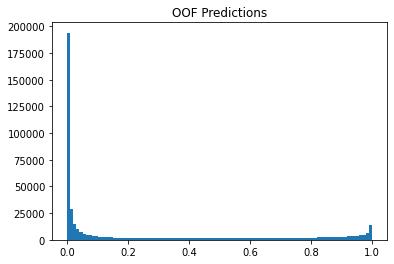

In [ ]:
# PLOT OOF PREDICTIONS
plt.hist(oof_xgb.oof_pred.values, bins=100)
plt.title('OOF Predictions')
plt.show()

In [ ]:
# CLEAR VRAM, RAM FOR INFERENCE BELOW
del oof_xgb, oof
_ = gc.collect()

# Feature Importance

In [ ]:
import matplotlib.pyplot as plt

df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'xgb_feature_importance_v{VER}.csv',index=False)

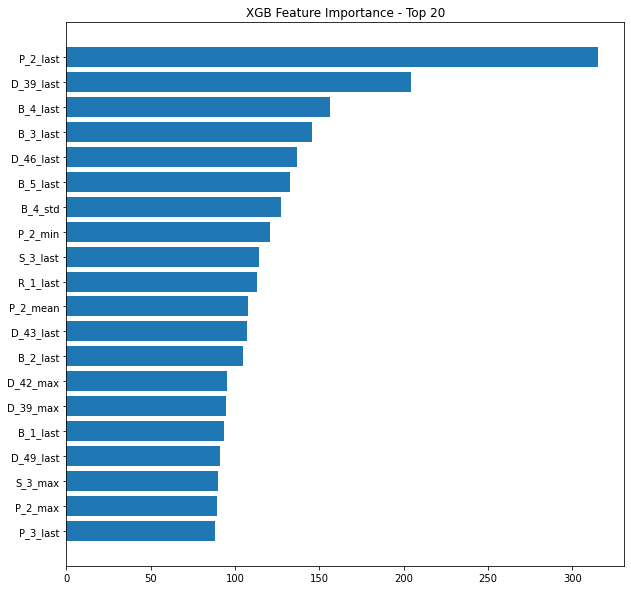

In [ ]:
NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Process and Feature Engineer Test Data


In [ ]:
_ = gc.collect()

In [ ]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4
TEST_PATH = 'test.parquet'

print(f'Reading test data...')
test = read_file(path = TEST_PATH, usecols = ['customer_ID','S_2'])
test = handle_na(test,NAN_VALUE)
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

Reading test data...
shape of data: (11363762, 2)
We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[2841209, 2839857, 2842105, 2840591]


In [ ]:
os.chdir('/content/drive/MyDrive/Amex/parquet/')

# Infer Test

In [ ]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test = read_file(path = TEST_PATH)
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    test = process_and_feature_engineer(test,cat_features, num_features, growth)
    for m,k in col_added:
      test[f'{m}_{k}']= test[m]*test[k] 
    if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
    else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    
    # TEST DATA FOR XGB
    X_test = test[FEATURES]
    dtest = xgb.DMatrix(data=X_test)
    del test 
    del X_test
    gc.collect()

    # INFER XGB MODELS ON TEST DATA
    model = xgb.Booster()
    model.load_model(f'XGB_v{VER}_fold0.xgb')
    #model.load_model('XGB_full.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'XGB_v{VER}_fold{fold}.xgb')
        #model.load_model(f'XGB_full.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del dtest, model
    _ = gc.collect()


Reading test data...
shape of data: (11363762, 190)
=> Test part 1 has shape (2841209, 190)
shape after engineering (231155, 1114)

Reading test data...
shape of data: (11363762, 190)
=> Test part 2 has shape (2839857, 190)
shape after engineering (231155, 1114)

Reading test data...
shape of data: (11363762, 190)
=> Test part 3 has shape (2842105, 190)
shape after engineering (231155, 1114)

Reading test data...
shape of data: (11363762, 190)
=> Test part 4 has shape (2840591, 190)
shape after engineering (231156, 1114)


# Create Submission CSV

In [ ]:
# WRITE SUBMISSION FILE
#test_preds = np.concatenate(test_preds).to_numpy()
test = pd.DataFrame(index=customers,data={'prediction':[test_preds]})
sub = pd.read_csv('/content/drive/MyDrive/Amex/parquet/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test['prediction'], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

TypeError: ignored

In [ ]:
sub.to_csv(f'/content/drive/My Drive/Amex/parquet/XGB Baseline/submission.csv',index=False)

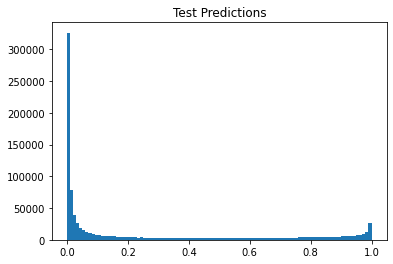

In [ ]:
# PLOT PREDICTIONS
plt.hist(sub.to_pandas().prediction, bins=100)
plt.title('Test Predictions')
plt.show()

Feature Engineering

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state=100,
                                                    stratify=y)